In [1]:
# annotation과 image 디렉토리 설정. annotation디렉토리에 있는 파일 확인. 
import os
from pathlib import Path

HOME_DIR = str(Path.home())

ANNO_DIR = os.path.join(HOME_DIR, 'DLCV/data/Dog/annotation')
IMAGE_DIR = os.path.join(HOME_DIR, 'DLCV/data/Dog/images')
print(ANNO_DIR)

files = os.listdir(ANNO_DIR)
print('파일 개수는:',len(files))
print(files)

/home/dsl001/DLCV/data/Dog/annotation
파일 개수는: 10001
['083b50287c95b03d.xml', '5d642c3e9249dd53.xml', '95f9091f51c309a9.xml', '51eb9b5df5dafbd8.xml', '76358dba8335eb35.xml', '76c8d8db7038a237.xml', 'de9b32f0f0c851b7.xml', 'a2624a4369484497.xml', 'afddf035cd0fbdea.xml', 'f62975b36ea99515.xml', '0904843637e366ae.xml', '9d768c7234326cfd.xml', '7c0a6aab76d3b6d9.xml', '100a84d3a3e585ff.xml', 'f54103c441eb38bf.xml', 'e08f5642715b2391.xml', 'dc5d0d61a962a50e.xml', '27c6c233e522ec69.xml', '9b4f1951cc1788bf.xml', '8449a150dcb0a223.xml', '6bcf67cc351a61c1.xml', '28c54747b3d027a3.xml', 'de0085dcb63da3e8.xml', '3e43d622f6637046.xml', 'cec940bc5f838708.xml', '1781d34e3d037caa.xml', 'efff6c3e4643a862.xml', 'f81c19454a5ad42c.xml', '198fe88c9047f155.xml', 'ae434977a9e13304.xml', 'dae8524e010260ed.xml', '0d624305106a9f9d.xml', '0990cae9f574c0ad.xml', '336076f29f639040.xml', '0ac5f8e4e9493ba8.xml', '7e0a3a7b6039228b.xml', '55b892b3f2411992.xml', '1b7d803e545ba1b4.xml', 'd8483106d0a94ba2.xml', '3b4d46be49

In [2]:
import glob
import xml.etree.ElementTree as ET

classes_map = {'Dog':0}

def xml_to_csv(path, output_filename):
    xml_list = []
    # xml 확장자를 가진 모든 파일의 절대 경로로 xml_file할당. 
    with open(output_filename, "w") as train_csv_file:
        for xml_file in glob.glob(path + '/*.xml'):
            # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
            tree = ET.parse(xml_file)
            root = tree.getroot()
            # 파일내에 있는 모든 object Element를 찾음. 
            full_image_name = os.path.join(IMAGE_DIR, root.find('filename').text)
            value_str_list = ' '
            for obj in root.findall('object'):
                xmlbox = obj.find('bndbox')
                class_name = obj.find('name').text
                x1 = int(xmlbox.find('xmin').text)
                y1 = int(xmlbox.find('ymin').text)
                x2 = int(xmlbox.find('xmax').text)
                y2 = int(xmlbox.find('ymax').text)
                # 
                class_id = classes_map[class_name]
                value_str = ('{0},{1},{2},{3},{4}').format(x1, y1, x2, y2, class_id)
                # object별 정보를 tuple형태로 object_list에 저장. 
                value_str_list = value_str_list+value_str+' '
        
            train_csv_file.write(full_image_name+' '+ value_str_list+'\n')
        # xml file 찾는 for loop 종료 

In [3]:
# xml_to_csv(ANNO_DIR, os.path.join(ANNO_DIR,'Dog_annotation.csv'))
# print(os.path.join(ANNO_DIR,'Dog_annotation.csv'))

In [4]:
# !cat /home/dsl001/DLCV/data/Dog/annotation/Dog_annotation.csv

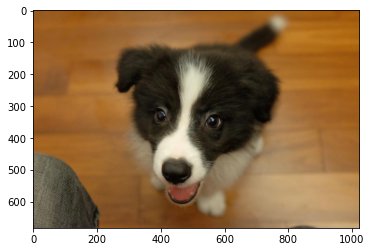

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cv2.cvtColor(cv2.imread('/home/dsl001/DLCV/data/Dog/images/f54103c441eb38bf.jpg'), cv2.COLOR_BGR2RGB))

In [2]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [3]:
import sys, os

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [8]:
from train import get_classes, get_anchors
from train import create_model, data_generator, data_generator_wrapper

BASE_DIR = os.path.join(HOME_DIR, 'DLCV/Detection/yolo/keras-yolo3')

## 학습을 위한 기반 환경 설정. annotation 파일 위치, epochs시 저장된 모델 파일, Object클래스 파일, anchor 파일.
annotation_path = os.path.join(ANNO_DIR, 'Dog_annotation.csv')
log_dir = os.path.join(BASE_DIR, 'snapshots/Dog/')
classes_path = os.path.join(BASE_DIR, 'model_data/Dog_classes.txt')
anchors_path = os.path.join(BASE_DIR,'model_data/yolo_anchors.txt')

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
print(class_names, num_classes)
print(anchors)

['Dog'] 1
[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 198.]
 [373. 326.]]


#### yolo 모델 학습을 위한 전반적인 파라미터를 config 클래스로 설정하고 필요시 이를 수정하여 학습. 

In [16]:
# csv annotation 파일을 읽어서 lines 리스트로 만듬. 
with open(annotation_path) as f:
    lines = f.readlines()

class config:
    #tiny yolo로 모델로 초기 weight 학습 원할 시 아래를 tiny-yolo.h5로 수정. 
    initial_weights_path=os.path.join(BASE_DIR, 'snapshots/Dog_detection/ep969-loss15.139-val_loss14.382.h5' )
    # input_shape는 고정. 
    input_shape=(416, 416)
    # epochs는 freeze, unfreeze 2 step에 따라 설정. 
    first_epochs=10
    first_initial_epochs=0
    second_epochs=10000
    second_initial_epochs=10
    # 학습시 batch size, train,valid건수, epoch steps 횟수  
    batch_size = 16
    val_split = 0.1   
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val
    train_epoch_steps = num_train//batch_size 
    val_epoch_steps =  num_val//batch_size
    
    anchors = get_anchors(anchors_path)
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    # epoch시 저장된 weight 파일 디렉토리 
    log_dir = os.path.join(BASE_DIR, 'snapshots/Dog_detection/')
    
print('Class name:', config.class_names,'\nNum classes:', config.num_classes)

Class name: ['Dog'] 
Num classes: 1


#### csv 파일을 입력 받아서 train 데이터와 valid 데이터 처리를 위한 data_generator_wrapper객체를 각각 생성.
* train용, valid 용 data_generator_wrapper는 Yolo 모델의 fit_generator()학습시 인자로 입력됨. 

In [10]:
def data_generator_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=random)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [11]:
def data_generator_wrapper_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random)

In [12]:
def create_generator(lines):
    
    train_data_generator = data_generator_wrapper_default(lines[:config.num_train], config.batch_size, 
                                                  config.input_shape, config.anchors, config.num_classes, random=100)
    
    valid_data_generator = data_generator_wrapper_default(lines[config.num_train:], config.batch_size, 
                                                  config.input_shape, config.anchors, config.num_classes, random=100)
    
    return train_data_generator, valid_data_generator

#### YOLO 모델 또는 tiny yolo 모델 반환. 초기 weight값은 pretrained된 yolo weight값으로 할당. 

In [13]:
# anchor 개수에 따라 tiny yolo 모델 또는 yolo 모델 반환. 
def create_yolo_model():
    is_tiny_version = len(config.anchors)==6 
    if is_tiny_version:
        model = create_tiny_model(config.input_shape, config.anchors, config.num_classes, 
            freeze_body=2, weights_path=config.initial_weights_path)
    else:
        model = create_model(config.input_shape, config.anchors, config.num_classes, 
            freeze_body=2, weights_path=config.initial_weights_path)
        
    return model 

#### callback 객체들을 생성. 

In [14]:
# Tensorboard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping callback 반환
def create_callbacks():
    logging = TensorBoard(log_dir=config.log_dir)
    checkpoint = ModelCheckpoint(config.log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1)
    
    #개별 callback들을 한꺼번에 list로 묶어서 반환
    return [logging, checkpoint, reduce_lr, early_stopping]

#### 학습 수행

In [17]:
# create_generator(), create_model(), create_callbacks() 수행. 
# from keras.utils import multi_gpu_model

train_data_generator, valid_data_generator = create_generator(lines)
dog_model = create_yolo_model()
callbacks_list = create_callbacks()

# 최초 모델은 주요 layer가 freeze되어 있음. 안정적인 loss를 확보하기 위해 주요 layer를 freeze한 상태로 먼저 학습. 
print('First train 시작')
dog_model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
dog_model.fit_generator(train_data_generator, steps_per_epoch=config.train_epoch_steps,
                        validation_data=valid_data_generator, validation_steps=config.val_epoch_steps,
                        epochs=config.first_epochs, initial_epoch=config.first_initial_epochs, 
                        callbacks=callbacks_list)

# 1단계 학습 완료 모델 저장. 
dog_model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# 모든 layer를 trainable=True로 설정하고 학습 수행. 
for i in range(len(dog_model.layers)):
    dog_model.layers[i].trainable = True
    
print('Second train 시작' )

# Tensorboard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping callback 반환
def create_callbacks():
    logging = TensorBoard(log_dir=config.log_dir)
    checkpoint = ModelCheckpoint(config.log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300, verbose=1)
    
    #개별 callback들을 한꺼번에 list로 묶어서 반환
    return [logging, checkpoint, reduce_lr]

callbacks_list = create_callbacks()
dog_model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) 
dog_model.fit_generator(train_data_generator, steps_per_epoch=config.train_epoch_steps,
                        validation_data=valid_data_generator, validation_steps=config.val_epoch_steps,
                        epochs=config.second_epochs, initial_epoch=config.second_initial_epochs,
                        callbacks=callbacks_list)

# 최종 학습 완료 모델 저장. 
dog_model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 1 classes.
Load weights /home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog_detection/ep969-loss15.139-val_loss14.382.h5.
Freeze the first 249 layers of total 252 layers.
First train 시작
Epoch 1/10
562/562 [==============================] - 637s 1s/step - loss: 15.3633 - val_loss: 14.9757
Epoch 2/10
562/562 [==============================] - 617s 1s/step - loss: 15.4188 - val_loss: 14.9923
Epoch 3/10
562/562 [==============================] - 597s 1s/step - loss: 15.4123 - val_loss: 14.7922
Epoch 4/10
562/562 [==============================] - 595s 1s/step - loss: 15.3771 - val_loss: 14.7613
Epoch 5/10
562/562 [==============================] - 608s 1s/step - loss: 15.4750 - val_loss: 14.7622
Epoch 6/10
562/562 [==============================] - 612s 1s/step - loss: 15.3593 - val_loss: 15.0002
Epoch 7/10
562/562 [==============================] - 605s 1s/step - loss: 15.3414 - val_loss: 14.7627
Epoch 8/10
562/562 [===========================

562/562 [==============================] - 614s 1s/step - loss: 6.4414 - val_loss: 7.3628
Epoch 154/10000
562/562 [==============================] - 625s 1s/step - loss: 6.3814 - val_loss: 6.9065
Epoch 155/10000
562/562 [==============================] - 617s 1s/step - loss: 6.4194 - val_loss: 7.4671
Epoch 156/10000
562/562 [==============================] - 617s 1s/step - loss: 6.4265 - val_loss: 6.9121
Epoch 157/10000
562/562 [==============================] - 610s 1s/step - loss: 6.3574 - val_loss: 7.1359
Epoch 158/10000
562/562 [==============================] - 613s 1s/step - loss: 6.3129 - val_loss: 7.5321
Epoch 159/10000
562/562 [==============================] - 605s 1s/step - loss: 6.3754 - val_loss: 6.8887
Epoch 160/10000
562/562 [==============================] - 624s 1s/step - loss: 6.4062 - val_loss: 7.2803
Epoch 161/10000
562/562 [==============================] - 618s 1s/step - loss: 6.2640 - val_loss: 7.3331
Epoch 162/10000
562/562 [==============================] - 624

562/562 [==============================] - 615s 1s/step - loss: 5.8400 - val_loss: 6.8796
Epoch 308/10000
562/562 [==============================] - 621s 1s/step - loss: 5.8629 - val_loss: 6.7088
Epoch 309/10000
562/562 [==============================] - 611s 1s/step - loss: 5.8373 - val_loss: 7.3153
Epoch 310/10000
562/562 [==============================] - 618s 1s/step - loss: 5.7948 - val_loss: 6.8378
Epoch 311/10000
562/562 [==============================] - 623s 1s/step - loss: 5.8204 - val_loss: 6.7577
Epoch 312/10000
562/562 [==============================] - 617s 1s/step - loss: 5.8112 - val_loss: 6.6370
Epoch 313/10000
562/562 [==============================] - 604s 1s/step - loss: 5.9016 - val_loss: 7.1216
Epoch 314/10000
562/562 [==============================] - 619s 1s/step - loss: 5.7934 - val_loss: 6.6071
Epoch 315/10000
562/562 [==============================] - 613s 1s/step - loss: 5.8041 - val_loss: 6.6928
Epoch 316/10000
562/562 [==============================] - 614

562/562 [==============================] - 616s 1s/step - loss: 5.6212 - val_loss: 7.1889
Epoch 462/10000
562/562 [==============================] - 612s 1s/step - loss: 5.5536 - val_loss: 6.7379
Epoch 463/10000
562/562 [==============================] - 619s 1s/step - loss: 5.5669 - val_loss: 6.6335
Epoch 464/10000
562/562 [==============================] - 606s 1s/step - loss: 5.6184 - val_loss: 7.1711
Epoch 465/10000
562/562 [==============================] - 610s 1s/step - loss: 5.5703 - val_loss: 6.8991
Epoch 466/10000
562/562 [==============================] - 619s 1s/step - loss: 5.5823 - val_loss: 6.7492
Epoch 467/10000
562/562 [==============================] - 616s 1s/step - loss: 5.5181 - val_loss: 6.7971
Epoch 468/10000
562/562 [==============================] - 615s 1s/step - loss: 5.5894 - val_loss: 6.9572
Epoch 469/10000
562/562 [==============================] - 621s 1s/step - loss: 5.5962 - val_loss: 6.7572
Epoch 470/10000
562/562 [==============================] - 609

562/562 [==============================] - 620s 1s/step - loss: 5.4247 - val_loss: 6.8016
Epoch 616/10000
562/562 [==============================] - 610s 1s/step - loss: 5.4343 - val_loss: 6.5980
Epoch 617/10000
562/562 [==============================] - 620s 1s/step - loss: 5.3841 - val_loss: 6.7163
Epoch 618/10000
562/562 [==============================] - 618s 1s/step - loss: 5.4867 - val_loss: 6.9372
Epoch 619/10000
562/562 [==============================] - 616s 1s/step - loss: 5.4847 - val_loss: 6.8641
Epoch 620/10000
562/562 [==============================] - 624s 1s/step - loss: 5.4830 - val_loss: 6.3875
Epoch 621/10000
562/562 [==============================] - 628s 1s/step - loss: 5.4099 - val_loss: 6.5338
Epoch 622/10000
562/562 [==============================] - 623s 1s/step - loss: 5.4112 - val_loss: 6.9042
Epoch 623/10000
562/562 [==============================] - 629s 1s/step - loss: 5.4528 - val_loss: 6.6882
Epoch 624/10000
562/562 [==============================] - 611

KeyboardInterrupt: 

#### 최종 학습된 모델을 로딩하여 Object Detection 수행. 

In [4]:
from yolo import YOLO
#keras-yolo에서 image처리를 주요 PIL로 수행. 
from PIL import Image

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

# dog_yolo = YOLO(model_path='/home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog/trained_weights_final.h5',
#                 anchors_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/yolo_anchors.txt',
#                 classes_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/Dog_classes.txt')

dog_yolo = YOLO(model_path='/home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog_detection/ep432-loss5.571-val_loss6.285.h5',
                anchors_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/yolo_anchors.txt',
                classes_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/Dog_classes.txt')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
/home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog_detection/ep432-loss5.571-val_loss6.285.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 이미지 Object Detection

(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (135, 16) (492, 333)
0.056124174036085606
[['Dog 1.00', (135, 16), (492, 333)]]


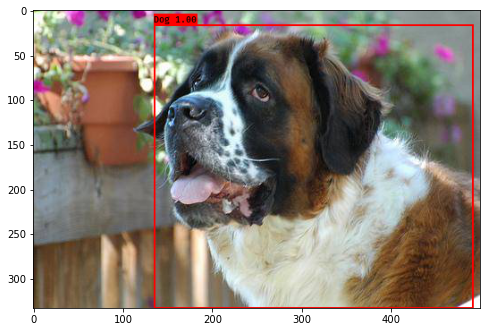

In [5]:
img = Image.open('/home/dsl001/DLCV/data/Dog_images/images/Dog_162.jpg')
detected_img, info = dog_yolo.detect_image(img)
print(info)
plt.figure(figsize=(8, 8))
plt.imshow(detected_img)

(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (7, 57) (299, 300)
0.05026975111104548
[['Dog 1.00', (7, 57), (299, 300)]]


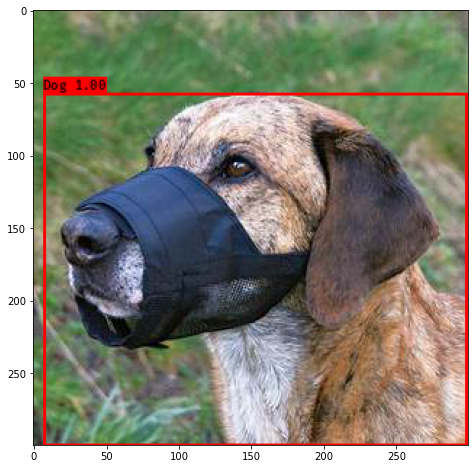

In [47]:
img = Image.open('/home/dsl001/DLCV/data/Dog_images/images/Muzzle_400.jpg')
detected_img, info = dog_yolo.detect_image(img)
print(info)
plt.figure(figsize=(8, 8))
plt.imshow(detected_img)

In [14]:
import numpy as np

In [20]:
info

[['No muzzle 0.82', (176, 129), (209, 158)]]

In [42]:
for data in info:
    label = data[0]
    rigth_top = data[1]
    left_bottom = data[2]
    
print(label, rigth_top, left_bottom)

Dog 0.32 (9, 505) (335, 824)


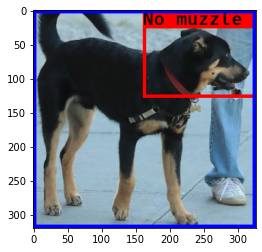

In [43]:
data = np.array(img)
plt.imshow(data[rigth_top[1]:left_bottom[1]+1, rigth_top[0]:left_bottom[0]+1, :])

In [21]:
Dog_list = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg' ]
for image_name in Dog_list:
    img = Image.open('/home/dsl001/{}'.format(image_name))
    detected_img = dog_yolo.detect_image(img)
    plt.figure(figsize=(8, 8))
    plt.imshow(detected_img)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dsl001/1.jpg'

In [21]:
Dog_list = ['Dog_0.jpg', 'Muzzle_371.jpg', 'Muzzle_364.jpg',
            'Nomuzzle_268.jpg', 'Nomuzzle_27.jpg', 'Nomuzzle_269.jpg' ]
for image_name in Dog_list:
    img = Image.open(os.path.join(IMAGE_DIR, image_name))
    detected_img = dog_yolo.detect_image(img)
    plt.figure(figsize=(8, 8))
    plt.imshow(detected_img)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dsl001/DLCV/data/Dog/images/Dog_0.jpg'

#### 영상 Object Detection 

In [5]:
import cv2
import time

def detect_video_yolo(model, input_path, output_path=""):
    
    start = time.time()
    cap = cv2.VideoCapture(input_path)
    
    #codec = cv2.VideoWriter_fourcc(*'DIVX')
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    vid_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, '원본 영상 FPS:',vid_fps, '원본 Frame 크기:', vid_size)
    index = 0
    while True:
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('프레임이 없거나 종료 되었습니다.')
            break
        start = time.time()
        # PIL Package를 내부에서 사용하므로 cv2에서 읽은 image_frame array를 다시 PIL의 Image형태로 변환해야 함.  
        image = Image.fromarray(image_frame)
        # 아래는 인자로 입력된 yolo객체의 detect_image()로 변환한다.
        detected_image, info = model.detect_image(image)
        # cv2의 video writer로 출력하기 위해 다시 PIL의 Image형태를 array형태로 변환 
        result = np.asarray(detected_image)
        index +=1
        print('#### frame:{0} 이미지 처리시간:{1}'.format(index, round(time.time()-start,3)))
        
        vid_writer.write(result)
    
    vid_writer.release()
    cap.release()
    print('### Video Detect 총 수행시간:', round(time.time()-start, 5))

In [6]:
detect_video_yolo(dog_yolo, '../../data/video/설명.mp4', '../../data/output/설명.avi')
!gsutil cp ../../data/output/NFL_yolo_01.avi gs://my_bucket_dlcv/data/output/NFL_yolo_01.avi

총 Frame 갯수: 12664 원본 영상 FPS: 29.97002997002997 원본 Frame 크기: (1280, 720)
(416, 416, 3)
Found 0 boxes for img
1.3457988670561463
#### frame:1 이미지 처리시간:1.35
(416, 416, 3)
Found 0 boxes for img
0.19548370502889156
#### frame:2 이미지 처리시간:0.199
(416, 416, 3)
Found 0 boxes for img
0.20100552891381085
#### frame:3 이미지 처리시간:0.205
(416, 416, 3)
Found 0 boxes for img
0.19382158701773733
#### frame:4 이미지 처리시간:0.198
(416, 416, 3)
Found 0 boxes for img
0.21027107490226626
#### frame:5 이미지 처리시간:0.214
(416, 416, 3)
Found 0 boxes for img
0.19387523201294243
#### frame:6 이미지 처리시간:0.198
(416, 416, 3)
Found 0 boxes for img
0.18860995094291866
#### frame:7 이미지 처리시간:0.193
(416, 416, 3)
Found 0 boxes for img
0.20054246997460723
#### frame:8 이미지 처리시간:0.206
(416, 416, 3)
Found 0 boxes for img
0.18561759998556226
#### frame:9 이미지 처리시간:0.189
(416, 416, 3)
Found 0 boxes for img
0.18724599201232195
#### frame:10 이미지 처리시간:0.191
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (478, 51) (654, 413)
0.20124716602731496
###

Found 1 boxes for img
Dog 1.00 (381, 131) (1051, 710)
0.21961101505439728
#### frame:76 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (384, 128) (1055, 713)
0.19847994297742844
#### frame:77 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (379, 133) (1058, 706)
0.2550302640302107
#### frame:78 이미지 처리시간:0.259
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (379, 132) (1044, 709)
0.2230853559449315
#### frame:79 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (381, 139) (1038, 697)
0.19840046297758818
#### frame:80 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (384, 134) (1029, 701)
0.205775290960446
#### frame:81 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (385, 129) (1033, 706)
0.2128807489061728
#### frame:82 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (392, 113) (1025, 679)
0.2116186060011387
#### frame:83 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (388, 134) (1036, 696)
0.20648421300575

Found 2 boxes for img
Dog 0.55 (729, 185) (1280, 699)
Dog 0.99 (102, 223) (767, 711)
0.21844928606878966
#### frame:147 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (100, 320) (772, 707)
0.20450418803375214
#### frame:148 이미지 처리시간:0.209
(416, 416, 3)
Found 0 boxes for img
0.8692746330052614
#### frame:149 이미지 처리시간:0.873
(416, 416, 3)
Found 0 boxes for img
0.23718755890149623
#### frame:150 이미지 처리시간:0.241
(416, 416, 3)
Found 0 boxes for img
0.22923167003318667
#### frame:151 이미지 처리시간:0.233
(416, 416, 3)
Found 0 boxes for img
0.2216839890461415
#### frame:152 이미지 처리시간:0.226
(416, 416, 3)
Found 0 boxes for img
0.20355021196883172
#### frame:153 이미지 처리시간:0.207
(416, 416, 3)
Found 0 boxes for img
0.21378059999551624
#### frame:154 이미지 처리시간:0.217
(416, 416, 3)
Found 0 boxes for img
0.22402176109608263
#### frame:155 이미지 처리시간:0.229
(416, 416, 3)
Found 0 boxes for img
0.5575290630804375
#### frame:156 이미지 처리시간:0.562
(416, 416, 3)
Found 0 boxes for img
0.4467501969775185
#### fra

Found 1 boxes for img
Dog 0.98 (771, 594) (1033, 720)
0.7946093160426244
#### frame:222 이미지 처리시간:0.799
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (772, 594) (1029, 720)
0.21637950604781508
#### frame:223 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (774, 590) (1027, 720)
0.21158779610414058
#### frame:224 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (774, 589) (1027, 720)
0.20940009295009077
#### frame:225 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (774, 590) (1027, 720)
0.21377746190410107
#### frame:226 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (773, 590) (1028, 720)
0.19576993107330054
#### frame:227 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (773, 589) (1027, 720)
0.20820807199925184
#### frame:228 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (773, 588) (1028, 720)
0.205155465984717
#### frame:229 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (771, 587) (1028, 720)
0.7427

Found 1 boxes for img
Dog 0.97 (775, 589) (1028, 720)
0.21622404002118856
#### frame:292 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (774, 587) (1028, 720)
0.2150484590092674
#### frame:293 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (772, 587) (1028, 720)
0.21272507798857987
#### frame:294 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (770, 591) (1029, 720)
0.21201214706525207
#### frame:295 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (770, 589) (1029, 720)
0.2121443289797753
#### frame:296 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (769, 591) (1029, 720)
0.21608354500494897
#### frame:297 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (767, 593) (1030, 720)
0.5598723170114681
#### frame:298 이미지 처리시간:0.564
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (767, 594) (1030, 720)
0.4555448810569942
#### frame:299 이미지 처리시간:0.459
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (763, 595) (1032, 720)
0.21273

Found 1 boxes for img
Dog 0.89 (773, 570) (1029, 720)
0.20272654190193862
#### frame:362 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (772, 570) (1029, 720)
0.19582467200234532
#### frame:363 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (772, 570) (1029, 720)
0.19857813604176044
#### frame:364 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (773, 571) (1029, 720)
0.20417682908009738
#### frame:365 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (773, 571) (1029, 720)
0.20239768200553954
#### frame:366 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (773, 571) (1029, 720)
0.2021996370749548
#### frame:367 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (772, 571) (1029, 720)
0.20862899092026055
#### frame:368 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (772, 571) (1029, 720)
0.24307415599469095
#### frame:369 이미지 처리시간:0.247
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (772, 571) (1029, 720)
0.1

Found 1 boxes for img
Dog 0.93 (717, 550) (1070, 720)
0.20380778796970844
#### frame:432 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (717, 549) (1070, 720)
0.21856079006101936
#### frame:433 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (718, 548) (1069, 720)
0.19995108793955296
#### frame:434 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (718, 549) (1069, 720)
0.20337507699150592
#### frame:435 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (718, 549) (1070, 720)
0.5900465509621426
#### frame:436 이미지 처리시간:0.594
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (718, 549) (1070, 720)
0.4678312459727749
#### frame:437 이미지 처리시간:0.471
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (718, 549) (1069, 720)
0.2310365040320903
#### frame:438 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (718, 549) (1069, 720)
0.22192543104756624
#### frame:439 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (718, 549) (1070, 720)
0.220

Found 1 boxes for img
Dog 0.91 (719, 551) (1067, 720)
0.20534405997022986
#### frame:502 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.21170340897515416
#### frame:503 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.18867923691868782
#### frame:504 이미지 처리시간:0.192
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (719, 552) (1067, 720)
0.7699816289823502
#### frame:505 이미지 처리시간:0.775
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.2638561889762059
#### frame:506 이미지 처리시간:0.268
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.2123055609408766
#### frame:507 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.20839754794724286
#### frame:508 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.20745609200093895
#### frame:509 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.212

Found 1 boxes for img
Dog 0.91 (719, 552) (1068, 720)
0.20413256296887994
#### frame:572 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (718, 552) (1068, 720)
0.20202653401065618
#### frame:573 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1068, 720)
0.23880649195052683
#### frame:574 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (719, 552) (1067, 720)
0.3652833050582558
#### frame:575 이미지 처리시간:0.37
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (719, 552) (1067, 720)
0.6220867310184985
#### frame:576 이미지 처리시간:0.626
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (720, 552) (1066, 720)
0.2088384210364893
#### frame:577 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (720, 552) (1067, 720)
0.2011695980327204
#### frame:578 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (720, 552) (1066, 720)
0.20684302609879524
#### frame:579 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (720, 552) (1066, 720)
0.21263

Found 1 boxes for img
Dog 1.00 (600, 449) (801, 595)
0.2056392690865323
#### frame:643 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 449) (801, 595)
0.20591691101435572
#### frame:644 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 450) (801, 595)
0.21827203396242112
#### frame:645 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 450) (801, 595)
0.19056015799287707
#### frame:646 이미지 처리시간:0.194
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 451) (801, 595)
0.20695544790942222
#### frame:647 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (601, 452) (801, 595)
0.2004884610651061
#### frame:648 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 452) (801, 594)
0.20395306102000177
#### frame:649 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (603, 453) (801, 594)
0.21703595691360533
#### frame:650 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (604, 452) (801, 594)
0.211047113058

Found 1 boxes for img
Dog 0.84 (587, 504) (812, 617)
0.2043970680097118
#### frame:714 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (585, 503) (812, 618)
0.21584523294586688
#### frame:715 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (586, 503) (812, 618)
0.2065864389296621
#### frame:716 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (585, 503) (813, 618)
0.20866502600256354
#### frame:717 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (584, 503) (815, 617)
0.20902296109125018
#### frame:718 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (584, 504) (814, 617)
0.23493881593458354
#### frame:719 이미지 처리시간:0.24
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (584, 505) (814, 617)
0.2031461939914152
#### frame:720 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (585, 506) (814, 616)
0.20963257201947272
#### frame:721 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (587, 507) (813, 616)
0.214635427924804

Found 1 boxes for img
Dog 0.97 (575, 493) (781, 608)
0.1992985859978944
#### frame:782 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (575, 492) (782, 608)
0.20358457206748426
#### frame:783 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (574, 489) (783, 609)
0.7725119349779561
#### frame:784 이미지 처리시간:0.776
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (574, 488) (784, 609)
0.21306731295771897
#### frame:785 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (574, 486) (784, 610)
0.21313931397162378
#### frame:786 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (574, 481) (785, 610)
0.20916291000321507
#### frame:787 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (575, 479) (785, 609)
0.21177134499885142
#### frame:788 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (574, 479) (785, 608)
0.20882787508890033
#### frame:789 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (575, 479) (785, 608)
0.20463812595

Found 1 boxes for img
Dog 1.00 (595, 454) (800, 601)
0.20777636102866381
#### frame:853 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 455) (800, 600)
0.22941862104926258
#### frame:854 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (592, 454) (801, 601)
0.21005581598728895
#### frame:855 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 453) (801, 601)
0.20666908693965524
#### frame:856 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 451) (800, 602)
0.2048386640381068
#### frame:857 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 449) (800, 602)
0.21505364403128624
#### frame:858 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 449) (800, 602)
0.7805793239967898
#### frame:859 이미지 처리시간:0.785
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 449) (800, 603)
0.21570229099597782
#### frame:860 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 448) (800, 604)
0.208808284020

Found 1 boxes for img
Dog 0.98 (568, 446) (797, 608)
0.2128253940027207
#### frame:924 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (567, 447) (798, 608)
0.2288416699739173
#### frame:925 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (568, 447) (797, 608)
0.20655538199935108
#### frame:926 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (568, 448) (797, 607)
0.2203408150235191
#### frame:927 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (588, 444) (803, 607)
0.21989468205720186
#### frame:928 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (587, 445) (803, 607)
0.21623297699261457
#### frame:929 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (588, 447) (803, 606)
0.21475768904201686
#### frame:930 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (588, 449) (803, 605)
0.19406142295338213
#### frame:931 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (589, 450) (803, 605)
0.18889797606971

Found 1 boxes for img
Dog 0.98 (556, 479) (800, 608)
0.20161276299040765
#### frame:995 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (556, 482) (801, 609)
0.27803028700873256
#### frame:996 이미지 처리시간:0.282
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (557, 483) (800, 609)
0.7052894269581884
#### frame:997 이미지 처리시간:0.709
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (556, 486) (800, 609)
0.20367489696945995
#### frame:998 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (557, 488) (799, 609)
0.2080156699521467
#### frame:999 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (556, 488) (798, 609)
0.19951084803324193
#### frame:1000 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (558, 489) (797, 609)
0.22580787795595825
#### frame:1001 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (558, 490) (796, 609)
0.2094347970560193
#### frame:1002 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (557, 490) (797, 610)
0.199019385

Found 1 boxes for img
Dog 0.97 (563, 505) (794, 618)
0.20415908400900662
#### frame:1065 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (567, 505) (792, 619)
0.21306063688825816
#### frame:1066 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (571, 499) (785, 606)
0.1979464420583099
#### frame:1067 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (573, 497) (785, 606)
0.20120155496988446
#### frame:1068 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (590, 494) (805, 606)
0.20012642396613955
#### frame:1069 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (572, 495) (786, 608)
0.1953689589863643
#### frame:1070 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (567, 496) (790, 607)
0.2073646589415148
#### frame:1071 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (563, 497) (794, 608)
0.22029720002319664
#### frame:1072 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (590, 496) (805, 606)
0.2052

Found 1 boxes for img
Dog 0.99 (595, 446) (800, 604)
0.2042353879660368
#### frame:1135 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 447) (800, 604)
0.20960496796760708
#### frame:1136 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 448) (800, 603)
0.20231850701384246
#### frame:1137 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 448) (800, 604)
0.21124791994225234
#### frame:1138 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 448) (800, 604)
0.21103861299343407
#### frame:1139 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 448) (800, 604)
0.21573545108549297
#### frame:1140 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (595, 448) (800, 604)
0.2002028200076893
#### frame:1141 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (595, 448) (800, 604)
0.20303468604106456
#### frame:1142 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (595, 448) (800, 604)
0.195

Found 1 boxes for img
Dog 0.99 (592, 446) (801, 603)
0.2379967289743945
#### frame:1205 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 446) (801, 603)
0.20771060092374682
#### frame:1206 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (593, 446) (801, 603)
0.19987398898229003
#### frame:1207 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 446) (801, 603)
0.20118900190573186
#### frame:1208 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 446) (801, 604)
0.20377949601970613
#### frame:1209 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 446) (801, 603)
0.20194965600967407
#### frame:1210 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 446) (801, 604)
0.20137895399238914
#### frame:1211 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 447) (801, 603)
0.20026794006116688
#### frame:1212 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 447) (801, 603)
0.20

Found 1 boxes for img
Dog 1.00 (595, 453) (800, 601)
0.2101282370276749
#### frame:1275 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 453) (800, 601)
0.220311896991916
#### frame:1276 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 453) (800, 601)
0.19122875900939107
#### frame:1277 이미지 처리시간:0.195
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 452) (800, 602)
0.20175063994247466
#### frame:1278 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 452) (800, 602)
0.21687735395971686
#### frame:1279 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 452) (800, 602)
0.20812502701301128
#### frame:1280 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 452) (800, 601)
0.20856443198863417
#### frame:1281 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 452) (800, 601)
0.2030406619887799
#### frame:1282 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 452) (800, 601)
0.21253

Found 1 boxes for img
Dog 1.00 (599, 452) (799, 601)
0.20273318397812545
#### frame:1345 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (600, 453) (799, 600)
0.20559328503441066
#### frame:1346 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (599, 452) (799, 600)
0.20809138903860003
#### frame:1347 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (600, 452) (799, 600)
0.210827418952249
#### frame:1348 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (600, 452) (799, 600)
0.21205060300417244
#### frame:1349 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (600, 452) (799, 601)
0.19717096199747175
#### frame:1350 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 453) (799, 601)
0.21419645904097706
#### frame:1351 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (599, 453) (799, 600)
0.2155504049733281
#### frame:1352 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 453) (800, 600)
0.2058

Found 1 boxes for img
Dog 1.00 (599, 450) (800, 599)
0.2041472919518128
#### frame:1415 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (599, 450) (800, 599)
0.21022081095725298
#### frame:1416 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 450) (800, 599)
0.22835423005744815
#### frame:1417 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 450) (800, 599)
0.20972696598619223
#### frame:1418 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 450) (800, 599)
0.20814069104380906
#### frame:1419 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 450) (800, 599)
0.2027681570034474
#### frame:1420 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 451) (800, 599)
0.20384912798181176
#### frame:1421 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 451) (800, 599)
0.19572358205914497
#### frame:1422 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (599, 451) (800, 599)
0.203

Found 1 boxes for img
Dog 0.98 (566, 450) (795, 606)
0.21235462208278477
#### frame:1485 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (566, 450) (795, 606)
0.20745951600838453
#### frame:1486 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (566, 449) (795, 606)
0.21560755197424442
#### frame:1487 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (566, 449) (795, 606)
0.20753510808572173
#### frame:1488 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (591, 444) (801, 605)
0.22351925598923117
#### frame:1489 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (591, 444) (801, 605)
0.2120209919521585
#### frame:1490 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (591, 444) (801, 606)
0.2438884450821206
#### frame:1491 이미지 처리시간:0.248
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (591, 443) (801, 606)
0.20369198999833316
#### frame:1492 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (568, 449) (794, 606)
0.2073

Found 1 boxes for img
Dog 0.98 (569, 446) (793, 606)
0.20843415695708245
#### frame:1555 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 446) (793, 606)
0.21021425107028335
#### frame:1556 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 446) (793, 606)
0.2121450479608029
#### frame:1557 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 446) (793, 606)
0.20666850393172354
#### frame:1558 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 446) (793, 606)
0.2367223909823224
#### frame:1559 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 446) (793, 606)
0.7902812889078632
#### frame:1560 이미지 처리시간:0.794
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (591, 440) (801, 608)
0.20095244399271905
#### frame:1561 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (591, 439) (801, 608)
0.20653896301519126
#### frame:1562 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (592, 439) (801, 608)
0.208701

Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.20283301593735814
#### frame:1625 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (592, 440) (801, 608)
0.21039808297064155
#### frame:1626 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.23612819600384682
#### frame:1627 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (592, 440) (801, 608)
0.2109792159171775
#### frame:1628 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.7800522380275652
#### frame:1629 이미지 처리시간:0.784
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.2013441229937598
#### frame:1630 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.21264680300373584
#### frame:1631 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.2064316909527406
#### frame:1632 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (592, 440) (801, 608)
0.219440

Found 1 boxes for img
Dog 0.98 (570, 445) (793, 606)
0.21884260093793273
#### frame:1695 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 445) (793, 606)
0.21586830099113286
#### frame:1696 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 445) (793, 606)
0.2244495589984581
#### frame:1697 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 444) (793, 606)
0.21867487102281302
#### frame:1698 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 444) (793, 606)
0.21634949499275535
#### frame:1699 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 444) (793, 606)
0.24012677697464824
#### frame:1700 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 444) (793, 606)
0.22428187995683402
#### frame:1701 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 444) (793, 606)
0.19568959495518357
#### frame:1702 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (570, 444) (793, 606)
0.20

Found 1 boxes for img
Dog 0.99 (773, 590) (1028, 720)
0.22087783506140113
#### frame:1765 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (770, 591) (1030, 720)
0.22260500094853342
#### frame:1766 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (770, 591) (1030, 720)
0.2327137989923358
#### frame:1767 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (771, 592) (1029, 720)
0.20955352997407317
#### frame:1768 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (769, 597) (1028, 720)
0.24535180197563022
#### frame:1769 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (768, 600) (1028, 720)
0.201982417027466
#### frame:1770 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (771, 600) (1027, 720)
0.7829293049871922
#### frame:1771 이미지 처리시간:0.787
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (773, 602) (1025, 720)
0.22662516101263463
#### frame:1772 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (771, 604) (1026, 720)


Found 1 boxes for img
Dog 0.99 (765, 594) (1030, 720)
0.19758220901712775
#### frame:1835 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (765, 594) (1030, 720)
0.20247357699554414
#### frame:1836 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (764, 595) (1031, 720)
0.754496727953665
#### frame:1837 이미지 처리시간:0.759
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (765, 595) (1030, 720)
0.2635082070482895
#### frame:1838 이미지 처리시간:0.268
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (764, 595) (1031, 720)
0.22034662903752178
#### frame:1839 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (763, 595) (1031, 720)
0.2002925550332293
#### frame:1840 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (764, 594) (1031, 720)
0.21874603105243295
#### frame:1841 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (764, 596) (1031, 720)
0.20300966990180314
#### frame:1842 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (763, 596) (1031, 720

Found 1 boxes for img
Dog 0.94 (774, 575) (1030, 720)
0.21684917202219367
#### frame:1905 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (776, 575) (1029, 720)
0.21736296301241964
#### frame:1906 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (778, 575) (1029, 720)
0.21482021803967655
#### frame:1907 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (779, 575) (1029, 720)
0.21267095592338592
#### frame:1908 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (777, 575) (1029, 720)
0.20729480497539043
#### frame:1909 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (777, 575) (1029, 720)
0.7942420940380543
#### frame:1910 이미지 처리시간:0.799
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (777, 575) (1029, 720)
0.24404730496462435
#### frame:1911 이미지 처리시간:0.249
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (777, 574) (1029, 720)
0.2102540269261226
#### frame:1912 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (778, 574) (1029, 72

Found 1 boxes for img
Dog 0.95 (785, 573) (1031, 720)
0.21146880299784243
#### frame:1975 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (786, 573) (1031, 720)
0.20573028805665672
#### frame:1976 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (786, 573) (1031, 720)
0.21598588395863771
#### frame:1977 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (786, 573) (1031, 720)
0.20315214002039284
#### frame:1978 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (786, 574) (1031, 720)
0.21581073105335236
#### frame:1979 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (785, 574) (1031, 720)
0.2161601569969207
#### frame:1980 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (785, 574) (1031, 720)
0.2163779439870268
#### frame:1981 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (785, 575) (1031, 720)
0.21095929795410484
#### frame:1982 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (786, 575) (1031, 720)


Found 1 boxes for img
Dog 0.99 (786, 590) (1035, 720)
0.44605069991666824
#### frame:2045 이미지 처리시간:0.45
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (786, 590) (1035, 720)
0.21757191698998213
#### frame:2046 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (786, 590) (1035, 720)
0.21218043204862624
#### frame:2047 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (786, 590) (1034, 720)
0.20957439090125263
#### frame:2048 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (786, 589) (1034, 720)
0.21752607997041196
#### frame:2049 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (785, 590) (1034, 720)
0.21684331609867513
#### frame:2050 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (785, 589) (1033, 720)
0.2153150460217148
#### frame:2051 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (785, 589) (1033, 720)
0.25380198599305004
#### frame:2052 이미지 처리시간:0.259
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (785, 589) (1033, 7

Found 1 boxes for img
Dog 0.98 (772, 589) (1031, 720)
0.21278401906602085
#### frame:2115 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (772, 589) (1031, 720)
0.22286339802667499
#### frame:2116 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720)
0.24515557603444904
#### frame:2117 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720)
0.2182796929264441
#### frame:2118 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720)
0.20873221999499947
#### frame:2119 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720)
0.7505178520223126
#### frame:2120 이미지 처리시간:0.754
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720)
0.24767930596135557
#### frame:2121 이미지 처리시간:0.251
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720)
0.20622765098232776
#### frame:2122 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (771, 589) (1031, 720

Found 1 boxes for img
Dog 0.98 (775, 587) (1030, 720)
0.5426009229850024
#### frame:2185 이미지 처리시간:0.546
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (775, 588) (1030, 720)
0.22740120394155383
#### frame:2186 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (775, 587) (1030, 720)
0.21172954991925508
#### frame:2187 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (776, 587) (1030, 720)
0.22328974201809615
#### frame:2188 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (777, 588) (1030, 720)
0.2154594549210742
#### frame:2189 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (779, 588) (1030, 720)
0.2234014559071511
#### frame:2190 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (780, 588) (1030, 720)
0.2073452619370073
#### frame:2191 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (780, 588) (1030, 720)
0.24867013096809387
#### frame:2192 이미지 처리시간:0.253
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (779, 588) (1030, 720)

Found 1 boxes for img
Dog 0.97 (785, 575) (1030, 720)
0.22010765899904072
#### frame:2255 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (785, 575) (1030, 720)
0.1998797879787162
#### frame:2256 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (785, 575) (1030, 720)
0.20988322200719267
#### frame:2257 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (785, 575) (1030, 720)
0.216407647007145
#### frame:2258 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (785, 576) (1030, 720)
0.2128682240145281
#### frame:2259 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (785, 576) (1030, 720)
0.21670285996515304
#### frame:2260 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (787, 576) (1030, 720)
0.20930399897042662
#### frame:2261 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (787, 575) (1030, 720)
0.19926884991582483
#### frame:2262 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (788, 575) (1031, 720)


Found 1 boxes for img
Dog 0.97 (745, 617) (1053, 715)
0.23052496300078928
#### frame:2325 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (709, 631) (1112, 714)
0.20900772407185286
#### frame:2326 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.45 (706, 637) (1107, 718)
0.21752805705182254
#### frame:2327 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (737, 636) (1080, 719)
0.21295123198069632
#### frame:2328 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (750, 635) (1062, 719)
0.2554548510815948
#### frame:2329 이미지 처리시간:0.26
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (743, 635) (1081, 718)
0.21733284695073962
#### frame:2330 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (751, 628) (1062, 714)
0.48806533706374466
#### frame:2331 이미지 처리시간:0.492
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (768, 624) (1019, 711)
0.502109806984663
#### frame:2332 이미지 처리시간:0.506
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (751, 617) (988, 711)

Found 1 boxes for img
Dog 0.34 (536, 395) (764, 603)
0.19963243103120476
#### frame:2396 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 0.41 (532, 376) (794, 615)
0.2125793379964307
#### frame:2397 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.56 (535, 376) (799, 617)
0.21648784005083144
#### frame:2398 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.62 (533, 374) (793, 618)
0.20977389998733997
#### frame:2399 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.53 (520, 374) (779, 619)
0.21594837808515877
#### frame:2400 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.68 (520, 366) (785, 624)
0.2122523399302736
#### frame:2401 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.34 (512, 360) (772, 624)
0.21862788300495595
#### frame:2402 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.68 (518, 364) (743, 627)
0.20459584391210228
#### frame:2403 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (520, 360) (741, 628)
0.20394

Found 1 boxes for img
Dog 0.43 (532, 460) (822, 620)
0.21287286095321178
#### frame:2468 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.59 (542, 461) (816, 622)
0.225362368975766
#### frame:2469 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (550, 463) (813, 621)
0.22090250300243497
#### frame:2470 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (553, 464) (805, 622)
0.2224408920155838
#### frame:2471 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 463) (778, 623)
0.21332380804233253
#### frame:2472 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (559, 463) (777, 623)
0.2128169370116666
#### frame:2473 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (553, 461) (777, 621)
0.21211618999950588
#### frame:2474 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (546, 457) (778, 621)
0.2708572200499475
#### frame:2475 이미지 처리시간:0.275
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (542, 455) (781, 621)
0.367338

Found 1 boxes for img
Dog 0.74 (504, 453) (840, 630)
0.24531840404961258
#### frame:2538 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 0.67 (499, 458) (839, 630)
0.22549437393900007
#### frame:2539 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.66 (499, 457) (838, 628)
0.19852838292717934
#### frame:2540 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 0.69 (498, 459) (846, 630)
0.2236958370776847
#### frame:2541 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.46 (499, 467) (845, 632)
0.2153895969968289
#### frame:2542 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.67 (535, 463) (795, 621)
0.21811539796181023
#### frame:2543 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (537, 465) (778, 622)
0.21536799403838813
#### frame:2544 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (539, 470) (774, 623)
0.25515026098582894
#### frame:2545 이미지 처리시간:0.259
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (536, 468) (774, 624)
0.21062

Found 1 boxes for img
Dog 0.98 (561, 464) (778, 623)
0.7799285780638456
#### frame:2608 이미지 처리시간:0.784
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (559, 464) (778, 623)
0.20632119197398424
#### frame:2609 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (556, 464) (785, 621)
0.2163170309504494
#### frame:2610 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (582, 462) (817, 614)
0.20905975601635873
#### frame:2611 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (580, 463) (826, 615)
0.2115287350025028
#### frame:2612 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.82 (579, 464) (827, 615)
0.2210682911099866
#### frame:2613 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (580, 464) (825, 615)
0.21379982004873455
#### frame:2614 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (582, 463) (821, 614)
0.2511748920660466
#### frame:2615 이미지 처리시간:0.256
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (582, 463) (821, 614)
0.58025362

Found 1 boxes for img
Dog 0.89 (554, 457) (808, 615)
0.21353580197319388
#### frame:2678 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (561, 456) (797, 614)
0.21904957003425807
#### frame:2679 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (563, 456) (793, 613)
0.2512048870557919
#### frame:2680 이미지 처리시간:0.257
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (562, 455) (794, 614)
0.7731610279297456
#### frame:2681 이미지 처리시간:0.777
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (561, 455) (796, 614)
0.2164563019759953
#### frame:2682 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (557, 455) (805, 614)
0.22136117704212666
#### frame:2683 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (578, 455) (818, 612)
0.21682689804583788
#### frame:2684 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (574, 455) (823, 614)
0.21377428190317005
#### frame:2685 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (574, 455) (824, 614)
0.21690

Found 1 boxes for img
Dog 0.96 (549, 450) (783, 617)
0.20783687802031636
#### frame:2748 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (549, 450) (782, 618)
0.2538532140897587
#### frame:2749 이미지 처리시간:0.258
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (550, 451) (783, 618)
0.7892664080718532
#### frame:2750 이미지 처리시간:0.794
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (550, 451) (791, 618)
0.21144909400027245
#### frame:2751 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.69 (547, 452) (812, 618)
0.2105659939115867
#### frame:2752 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.50 (553, 440) (847, 629)
0.22349755303002894
#### frame:2753 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.45 (552, 442) (848, 629)
0.210771864047274
#### frame:2754 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.43 (547, 453) (816, 617)
0.2139212751062587
#### frame:2755 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.47 (547, 453) (816, 618)
0.2225722

Found 1 boxes for img
Dog 0.68 (548, 454) (814, 616)
0.206035777926445
#### frame:2818 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (552, 453) (796, 617)
0.20835903997067362
#### frame:2819 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (552, 454) (788, 617)
0.2108546580420807
#### frame:2820 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (553, 454) (790, 617)
0.7750736260786653
#### frame:2821 이미지 처리시간:0.78
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (552, 454) (798, 618)
0.2232884969562292
#### frame:2822 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.65 (545, 455) (818, 617)
0.21181010000873357
#### frame:2823 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (573, 451) (828, 616)
0.20656314201187342
#### frame:2824 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.56 (572, 451) (829, 616)
0.21666178689338267
#### frame:2825 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.72 (572, 454) (828, 616)
0.2232183460

Found 1 boxes for img
Dog 0.91 (576, 458) (822, 611)
0.22498632397037
#### frame:2888 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (575, 455) (823, 612)
0.20126960100606084
#### frame:2889 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (576, 454) (821, 612)
0.21238656004425138
#### frame:2890 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (552, 454) (811, 618)
0.2172138630412519
#### frame:2891 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (556, 454) (803, 618)
0.21353538008406758
#### frame:2892 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (555, 452) (802, 618)
0.2125919929239899
#### frame:2893 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (557, 452) (803, 617)
0.21473175194114447
#### frame:2894 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (554, 452) (808, 617)
0.7805120829725638
#### frame:2895 이미지 처리시간:0.784
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (552, 452) (812, 617)
0.2170610

Found 1 boxes for img
Dog 0.45 (542, 447) (816, 618)
0.2627701780293137
#### frame:2958 이미지 처리시간:0.268
(416, 416, 3)
Found 1 boxes for img
Dog 0.45 (532, 440) (823, 637)
0.8001146690221503
#### frame:2959 이미지 처리시간:0.804
(416, 416, 3)
Found 1 boxes for img
Dog 0.46 (531, 441) (823, 637)
0.23043339897412807
#### frame:2960 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.45 (542, 447) (815, 617)
0.23135894699953496
#### frame:2961 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.46 (542, 447) (816, 617)
0.22447407792788
#### frame:2962 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.48 (542, 447) (816, 617)
0.23452955903485417
#### frame:2963 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 0.48 (542, 447) (817, 618)
0.20869406091514975
#### frame:2964 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.53 (542, 448) (817, 618)
0.5631971139227971
#### frame:2965 이미지 처리시간:0.567
(416, 416, 3)
Found 1 boxes for img
Dog 0.52 (542, 448) (817, 618)
0.4438176

Found 1 boxes for img
Dog 0.53 (550, 445) (812, 615)
0.21098210907075554
#### frame:3028 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (550, 446) (812, 615)
0.21667156601324677
#### frame:3029 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.50 (551, 445) (812, 616)
0.21866783394943923
#### frame:3030 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.47 (550, 445) (813, 616)
0.21607939002569765
#### frame:3031 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.49 (550, 446) (813, 616)
0.25367269094567746
#### frame:3032 이미지 처리시간:0.259
(416, 416, 3)
Found 1 boxes for img
Dog 0.50 (551, 446) (813, 616)
0.20911482896190137
#### frame:3033 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.52 (578, 442) (820, 614)
0.21209870092570782
#### frame:3034 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (578, 442) (820, 614)
0.2003376130014658
#### frame:3035 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (578, 442) (820, 614)
0.2073

Found 1 boxes for img
Dog 0.76 (575, 452) (822, 614)
0.22179374797269702
#### frame:3098 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.74 (575, 452) (823, 613)
0.21081324899569154
#### frame:3099 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (575, 452) (823, 614)
0.21088673907797784
#### frame:3100 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (576, 451) (823, 613)
0.1992072849534452
#### frame:3101 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 0.71 (574, 450) (823, 614)
0.2598869629437104
#### frame:3102 이미지 처리시간:0.264
(416, 416, 3)
Found 1 boxes for img
Dog 0.59 (574, 450) (823, 614)
0.20859857206232846
#### frame:3103 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.57 (547, 454) (818, 618)
0.21781225397717208
#### frame:3104 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.61 (547, 454) (817, 618)
0.2122088719625026
#### frame:3105 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.60 (546, 454) (816, 618)
0.2029

Found 1 boxes for img
Dog 0.93 (585, 455) (816, 619)
0.2025530590908602
#### frame:3168 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (584, 455) (816, 619)
0.202308502048254
#### frame:3169 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (584, 455) (816, 619)
0.21492844203021377
#### frame:3170 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (584, 454) (816, 619)
0.2064864659914747
#### frame:3171 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (584, 454) (816, 619)
0.2096735950326547
#### frame:3172 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (583, 454) (817, 618)
0.21280791505705565
#### frame:3173 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (583, 456) (816, 619)
0.20607302302960306
#### frame:3174 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (583, 456) (816, 619)
0.20802268898114562
#### frame:3175 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (584, 457) (815, 618)
0.21225956

Found 1 boxes for img
Dog 0.92 (581, 460) (817, 618)
0.4505513980984688
#### frame:3238 이미지 처리시간:0.454
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (581, 460) (817, 618)
0.22171424294356257
#### frame:3239 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (581, 461) (817, 618)
0.21078614401631057
#### frame:3240 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (582, 460) (816, 618)
0.22254455101210624
#### frame:3241 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (581, 460) (817, 618)
0.2038878509774804
#### frame:3242 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (581, 460) (817, 617)
0.222456036019139
#### frame:3243 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (581, 460) (817, 617)
0.20706560497637838
#### frame:3244 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (581, 460) (817, 617)
0.2536810180172324
#### frame:3245 이미지 처리시간:0.258
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (580, 460) (817, 618)
0.430333

Found 1 boxes for img
Dog 0.95 (585, 461) (815, 618)
0.22011223901063204
#### frame:3308 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (584, 462) (815, 618)
0.2166916700080037
#### frame:3309 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (584, 461) (815, 618)
0.22718257398810238
#### frame:3310 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (585, 461) (815, 617)
0.21661855396814644
#### frame:3311 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (584, 462) (815, 617)
0.21663574897684157
#### frame:3312 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (584, 462) (815, 617)
0.20936337404418737
#### frame:3313 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (585, 461) (815, 618)
0.2502142930170521
#### frame:3314 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (584, 461) (815, 618)
0.21494737605098635
#### frame:3315 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (585, 462) (814, 619)
0.2283

Found 1 boxes for img
Dog 0.78 (551, 457) (805, 618)
0.2161463339580223
#### frame:3378 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (551, 457) (806, 618)
0.7760031420039013
#### frame:3379 이미지 처리시간:0.781
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (554, 457) (806, 620)
0.2194637149805203
#### frame:3380 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (582, 456) (816, 618)
0.20715766097418964
#### frame:3381 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (555, 460) (807, 619)
0.2164962189272046
#### frame:3382 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (556, 461) (806, 620)
0.21102611592505127
#### frame:3383 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (556, 462) (806, 620)
0.20650448300875723
#### frame:3384 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (555, 461) (807, 620)
0.22054043202660978
#### frame:3385 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (554, 461) (807, 620)
0.76534887

Found 1 boxes for img
Dog 0.88 (553, 460) (808, 620)
0.3784245119895786
#### frame:3448 이미지 처리시간:0.382
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (553, 461) (808, 620)
0.6176279030041769
#### frame:3449 이미지 처리시간:0.621
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (553, 461) (808, 620)
0.2149526330176741
#### frame:3450 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (553, 461) (808, 620)
0.22638308303430676
#### frame:3451 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (553, 461) (808, 620)
0.2224404530134052
#### frame:3452 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (553, 461) (808, 620)
0.2144905119203031
#### frame:3453 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (553, 461) (808, 620)
0.2176531390286982
#### frame:3454 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (552, 461) (809, 620)
0.24407878599595279
#### frame:3455 이미지 처리시간:0.249
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (553, 461) (808, 620)
0.21160102

Found 1 boxes for img
Dog 0.86 (585, 456) (816, 618)
0.22119852306786925
#### frame:3518 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (584, 457) (816, 618)
0.21427973208483309
#### frame:3519 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (582, 458) (817, 618)
0.23657449800521135
#### frame:3520 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (581, 458) (817, 618)
0.6970656169578433
#### frame:3521 이미지 처리시간:0.701
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (581, 460) (817, 618)
0.33006536203902215
#### frame:3522 이미지 처리시간:0.334
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (582, 460) (817, 618)
0.20919665193650872
#### frame:3523 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (583, 460) (816, 617)
0.21939668396953493
#### frame:3524 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (582, 463) (816, 618)
0.21800900890957564
#### frame:3525 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (580, 463) (817, 620)
0.21

Found 1 boxes for img
Dog 0.90 (583, 455) (816, 619)
0.20558813703246415
#### frame:3588 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (584, 455) (817, 620)
0.21377254708204418
#### frame:3589 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (584, 455) (817, 620)
0.21546405099797994
#### frame:3590 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (581, 455) (818, 619)
0.2048719759332016
#### frame:3591 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.78 (580, 455) (818, 619)
0.20707202795892954
#### frame:3592 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.80 (580, 458) (818, 620)
0.21092026389669627
#### frame:3593 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (551, 461) (807, 620)
0.2494889199733734
#### frame:3594 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (581, 460) (818, 619)
0.3686667359434068
#### frame:3595 이미지 처리시간:0.373
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (581, 460) (817, 619)
0.6319

Found 1 boxes for img
Dog 0.93 (586, 459) (814, 613)
0.22684544196818024
#### frame:3658 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (587, 459) (813, 614)
0.24598795699421316
#### frame:3659 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (586, 459) (812, 615)
0.2185023290803656
#### frame:3660 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (562, 462) (794, 618)
0.2153105129254982
#### frame:3661 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (558, 463) (787, 618)
0.23029884207062423
#### frame:3662 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (555, 464) (784, 620)
0.20106710609979928
#### frame:3663 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (554, 464) (784, 619)
0.22220260894391686
#### frame:3664 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (550, 461) (785, 619)
0.21321933588478714
#### frame:3665 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (552, 459) (785, 620)
0.2172

Found 1 boxes for img
Dog 0.79 (549, 451) (795, 618)
0.21140361099969596
#### frame:3728 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.75 (546, 451) (794, 618)
0.20225093606859446
#### frame:3729 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.76 (546, 452) (794, 618)
0.2014125830028206
#### frame:3730 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (547, 452) (794, 618)
0.2044943009968847
#### frame:3731 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (548, 452) (794, 618)
0.5749392209108919
#### frame:3732 이미지 처리시간:0.58
(416, 416, 3)
Found 1 boxes for img
Dog 0.75 (547, 452) (794, 618)
0.4406726580346003
#### frame:3733 이미지 처리시간:0.444
(416, 416, 3)
Found 1 boxes for img
Dog 0.75 (547, 452) (794, 618)
0.21160901698749512
#### frame:3734 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.74 (546, 452) (794, 618)
0.2143410659627989
#### frame:3735 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.76 (547, 452) (794, 618)
0.2174405

Found 1 boxes for img
Dog 0.97 (563, 449) (797, 621)
0.21794535999651998
#### frame:3798 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (562, 449) (797, 621)
0.2106340330792591
#### frame:3799 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (561, 449) (797, 621)
0.21150113409385085
#### frame:3800 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (558, 448) (799, 621)
0.2783802959602326
#### frame:3801 이미지 처리시간:0.282
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (560, 449) (798, 621)
0.7320204420248047
#### frame:3802 이미지 처리시간:0.736
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (563, 448) (797, 621)
0.22031094110570848
#### frame:3803 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (562, 447) (798, 621)
0.2109212230425328
#### frame:3804 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (562, 448) (798, 621)
0.21226586494594812
#### frame:3805 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (563, 448) (798, 620)
0.21361

Found 1 boxes for img
Dog 0.99 (558, 462) (799, 623)
0.2169529179809615
#### frame:3868 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (558, 461) (801, 623)
0.2156359269283712
#### frame:3869 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 464) (800, 623)
0.21778156200889498
#### frame:3870 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 464) (801, 623)
0.7618349930271506
#### frame:3871 이미지 처리시간:0.767
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 465) (800, 623)
0.2672249299939722
#### frame:3872 이미지 처리시간:0.271
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 465) (800, 623)
0.20976843300741166
#### frame:3873 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 465) (800, 623)
0.21602058399003
#### frame:3874 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (557, 467) (802, 624)
0.211016787099652
#### frame:3875 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (557, 468) (802, 624)
0.21341299603

Found 1 boxes for img
Dog 0.99 (561, 464) (799, 622)
0.2030626500491053
#### frame:3938 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 465) (799, 622)
0.241008437005803
#### frame:3939 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (559, 465) (800, 622)
0.7893664910225198
#### frame:3940 이미지 처리시간:0.793
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 465) (799, 621)
0.21014899702277035
#### frame:3941 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 465) (799, 622)
0.2101826110156253
#### frame:3942 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 466) (799, 622)
0.20931448100600392
#### frame:3943 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (559, 466) (800, 622)
0.21876198903191835
#### frame:3944 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (559, 465) (800, 622)
0.1966000460088253
#### frame:3945 이미지 처리시간:0.2
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 463) (800, 622)
0.214871956

Found 1 boxes for img
Dog 0.97 (568, 451) (794, 616)
0.21060954697895795
#### frame:4008 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (566, 450) (795, 616)
0.21837241598404944
#### frame:4009 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (564, 449) (795, 617)
0.2045825159875676
#### frame:4010 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (563, 449) (795, 617)
0.20157086406834424
#### frame:4011 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (563, 450) (795, 616)
0.21336031204555184
#### frame:4012 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (562, 450) (796, 617)
0.21723149192985147
#### frame:4013 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (559, 449) (797, 617)
0.21645705495029688
#### frame:4014 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (559, 449) (797, 617)
0.2073833500035107
#### frame:4015 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (558, 451) (796, 617)
0.2083

Found 1 boxes for img
Dog 0.97 (565, 450) (796, 617)
0.21776223205961287
#### frame:4078 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (565, 451) (796, 617)
0.2076026570284739
#### frame:4079 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (563, 451) (797, 616)
0.21623310493305326
#### frame:4080 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (563, 451) (797, 617)
0.21986226399894804
#### frame:4081 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (563, 451) (797, 616)
0.21905347995925695
#### frame:4082 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (562, 451) (797, 617)
0.21077871997840703
#### frame:4083 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (562, 451) (797, 617)
0.7707216539420187
#### frame:4084 이미지 처리시간:0.775
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (562, 451) (797, 617)
0.25144657702185214
#### frame:4085 이미지 처리시간:0.255
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (563, 451) (797, 617)
0.2066

Found 1 boxes for img
Dog 0.98 (573, 454) (789, 613)
0.21071439690422267
#### frame:4148 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (571, 454) (790, 613)
0.2161156479269266
#### frame:4149 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (570, 455) (790, 613)
0.20949700206983835
#### frame:4150 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (570, 455) (790, 612)
0.21136455505620688
#### frame:4151 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (570, 455) (790, 613)
0.2243371520889923
#### frame:4152 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (569, 455) (791, 613)
0.21573340008035302
#### frame:4153 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 457) (791, 613)
0.20494327298365533
#### frame:4154 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (568, 457) (792, 613)
0.20837996201589704
#### frame:4155 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (569, 457) (791, 612)
0.21739

Found 1 boxes for img
Dog 0.99 (572, 454) (788, 614)
0.20983635599259287
#### frame:4218 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (572, 455) (788, 614)
0.21636695694178343
#### frame:4219 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (572, 455) (788, 614)
0.2110234689898789
#### frame:4220 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (571, 455) (788, 615)
0.20801036804914474
#### frame:4221 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (571, 456) (788, 615)
0.21547412604559213
#### frame:4222 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (572, 457) (788, 616)
0.2057681940495968
#### frame:4223 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (571, 456) (788, 615)
0.21025813603773713
#### frame:4224 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (571, 454) (788, 614)
0.21548901300411671
#### frame:4225 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (571, 453) (788, 614)
0.212567

Found 1 boxes for img
Dog 1.00 (567, 463) (792, 623)
0.22189495794009417
#### frame:4288 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (568, 462) (791, 623)
0.2152823880314827
#### frame:4289 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (569, 461) (789, 623)
0.22472530405502766
#### frame:4290 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (569, 461) (788, 623)
0.5150915930280462
#### frame:4291 이미지 처리시간:0.519
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (569, 461) (789, 622)
0.4988757069222629
#### frame:4292 이미지 처리시간:0.503
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (568, 461) (789, 623)
0.22804274095688015
#### frame:4293 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (568, 461) (790, 623)
0.22777943802066147
#### frame:4294 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (567, 461) (792, 623)
0.2172640839125961
#### frame:4295 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (564, 462) (797, 622)
0.20404

Found 1 boxes for img
Dog 0.99 (573, 458) (791, 614)
0.2118642299901694
#### frame:4358 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (573, 459) (788, 613)
0.20953654497861862
#### frame:4359 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (576, 459) (783, 614)
0.2096425020135939
#### frame:4360 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (577, 458) (780, 613)
0.20975026302039623
#### frame:4361 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (780, 613)
0.21126801206264645
#### frame:4362 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (782, 613)
0.2167271450161934
#### frame:4363 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (785, 613)
0.22555712598841637
#### frame:4364 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (574, 458) (788, 613)
0.7591285819653422
#### frame:4365 이미지 처리시간:0.763
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (573, 459) (789, 613)
0.234689

Found 1 boxes for img
Dog 0.97 (551, 459) (785, 613)
0.21017179801128805
#### frame:4428 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (551, 459) (786, 613)
0.21255726600065827
#### frame:4429 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (550, 459) (786, 614)
0.21559993200935423
#### frame:4430 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (552, 459) (786, 614)
0.21174117806367576
#### frame:4431 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (552, 459) (785, 614)
0.2131549910409376
#### frame:4432 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (551, 459) (785, 614)
0.21863055403809994
#### frame:4433 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (554, 459) (785, 613)
0.24724350194446743
#### frame:4434 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (554, 459) (785, 613)
0.5434856299543753
#### frame:4435 이미지 처리시간:0.547
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (555, 459) (786, 613)
0.447

Found 1 boxes for img
Dog 0.99 (563, 461) (790, 622)
0.23604841600172222
#### frame:4498 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (564, 460) (789, 622)
0.36718701710924506
#### frame:4499 이미지 처리시간:0.371
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (563, 460) (789, 623)
0.6196502660168335
#### frame:4500 이미지 처리시간:0.624
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (563, 461) (790, 624)
0.21493527304846793
#### frame:4501 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 462) (789, 624)
0.21045001491438597
#### frame:4502 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 463) (789, 624)
0.2107065380550921
#### frame:4503 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (564, 463) (789, 624)
0.2178918650606647
#### frame:4504 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 463) (790, 624)
0.20985773694701493
#### frame:4505 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 464) (790, 623)
0.2258

Found 1 boxes for img
Dog 0.99 (563, 471) (788, 623)
0.2110689430264756
#### frame:4565 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 470) (787, 623)
0.22006354993209243
#### frame:4566 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (563, 468) (788, 624)
0.20742835593409836
#### frame:4567 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 468) (788, 623)
0.20740805298555642
#### frame:4568 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 468) (787, 623)
0.2025636489270255
#### frame:4569 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 469) (788, 622)
0.773622744018212
#### frame:4570 이미지 처리시간:0.778
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (563, 468) (788, 622)
0.21647989796474576
#### frame:4571 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (564, 466) (788, 622)
0.21445439907256514
#### frame:4572 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 464) (789, 622)
0.210926

Found 1 boxes for img
Dog 0.98 (559, 453) (787, 613)
0.20926200202666223
#### frame:4635 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (558, 453) (787, 613)
0.20240075001493096
#### frame:4636 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (556, 452) (786, 613)
0.2052607290679589
#### frame:4637 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (556, 452) (786, 612)
0.2149067010032013
#### frame:4638 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (563, 452) (785, 611)
0.8247408210299909
#### frame:4639 이미지 처리시간:0.829
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (564, 453) (785, 611)
0.22319940105080605
#### frame:4640 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (566, 453) (785, 611)
0.23850672191474587
#### frame:4641 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (564, 454) (786, 611)
0.22391150693874806
#### frame:4642 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (564, 454) (786, 611)
0.2205

Found 1 boxes for img
Dog 0.99 (573, 458) (786, 614)
0.20824416598770767
#### frame:4705 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (574, 457) (786, 614)
0.21312579803634435
#### frame:4706 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 457) (785, 614)
0.2111970289843157
#### frame:4707 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (786, 615)
0.2200547680258751
#### frame:4708 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (785, 615)
0.2139636599458754
#### frame:4709 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (785, 615)
0.2178516349522397
#### frame:4710 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 458) (785, 615)
0.21342449507210404
#### frame:4711 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 459) (785, 615)
0.22022040304727852
#### frame:4712 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (575, 459) (785, 615)
0.20579

Found 1 boxes for img
Dog 0.99 (567, 457) (785, 619)
0.21498708298895508
#### frame:4775 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (568, 456) (785, 619)
0.2086245979880914
#### frame:4776 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (566, 457) (785, 619)
0.26119562902022153
#### frame:4777 이미지 처리시간:0.266
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (567, 457) (786, 620)
0.21839893399737775
#### frame:4778 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (567, 458) (786, 619)
0.21150710806250572
#### frame:4779 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (567, 458) (786, 619)
0.2038278579711914
#### frame:4780 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (566, 458) (787, 620)
0.21008256496861577
#### frame:4781 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (564, 459) (787, 620)
0.20506307191681117
#### frame:4782 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (565, 458) (787, 619)
0.207

Found 1 boxes for img
Dog 0.99 (561, 455) (789, 616)
0.21586654998827726
#### frame:4845 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 455) (789, 617)
0.2171783579979092
#### frame:4846 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 456) (789, 617)
0.21562705805990845
#### frame:4847 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (560, 457) (790, 617)
0.1992670240579173
#### frame:4848 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (559, 457) (790, 617)
0.20860964804887772
#### frame:4849 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 457) (789, 618)
0.23219957994297147
#### frame:4850 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 456) (790, 617)
0.23816226609051228
#### frame:4851 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 456) (790, 617)
0.21420553396455944
#### frame:4852 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (561, 456) (790, 617)
0.22067

Found 1 boxes for img
Dog 0.90 (503, 464) (748, 633)
0.20899249601643533
#### frame:4915 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (501, 466) (750, 633)
0.2135594099527225
#### frame:4916 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (503, 468) (752, 632)
0.22013296000659466
#### frame:4917 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (503, 470) (755, 630)
0.2503804999869317
#### frame:4918 이미지 처리시간:0.255
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (535, 483) (760, 638)
0.20077321003191173
#### frame:4919 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (534, 481) (762, 640)
0.20901076402515173
#### frame:4920 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (534, 479) (762, 641)
0.21431901003234088
#### frame:4921 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (536, 480) (761, 640)
0.19846079009585083
#### frame:4922 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (536, 480) (761, 640)
0.204

Found 1 boxes for img
Dog 0.98 (552, 457) (750, 628)
0.5463749719783664
#### frame:4985 이미지 처리시간:0.55
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (551, 456) (750, 627)
0.20944419398438185
#### frame:4986 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 456) (750, 628)
0.20690972998272628
#### frame:4987 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (549, 455) (750, 629)
0.20785629493184388
#### frame:4988 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (548, 454) (751, 628)
0.22409587493166327
#### frame:4989 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (515, 457) (746, 632)
0.215800398029387
#### frame:4990 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (548, 453) (751, 628)
0.21953363297507167
#### frame:4991 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (549, 452) (751, 628)
0.24078957899473608
#### frame:4992 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (549, 452) (751, 628)
0.210005

Found 1 boxes for img
Dog 0.91 (552, 455) (755, 623)
0.20284423499833792
#### frame:5055 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 0.80 (510, 454) (751, 632)
0.20594731403980404
#### frame:5056 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (548, 451) (754, 627)
0.788100523990579
#### frame:5057 이미지 처리시간:0.792
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (510, 453) (751, 633)
0.21078698302153498
#### frame:5058 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (548, 448) (754, 626)
0.2088350480189547
#### frame:5059 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (550, 448) (755, 625)
0.21390152210369706
#### frame:5060 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (555, 451) (763, 622)
0.20526845497079194
#### frame:5061 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (555, 453) (770, 622)
0.20592991006560624
#### frame:5062 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (557, 454) (779, 621)
0.199095

Found 1 boxes for img
Dog 0.78 (568, 435) (764, 629)
0.21672808204311877
#### frame:5125 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.82 (566, 435) (764, 628)
0.20603866199962795
#### frame:5126 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (562, 435) (764, 629)
0.7740514390170574
#### frame:5127 이미지 처리시간:0.778
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (563, 435) (764, 629)
0.24222799704875797
#### frame:5128 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (565, 434) (763, 628)
0.22885341697838157
#### frame:5129 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (566, 435) (764, 627)
0.2122460250975564
#### frame:5130 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (565, 436) (764, 628)
0.22071945702191442
#### frame:5131 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (565, 436) (763, 627)
0.2074148110114038
#### frame:5132 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (567, 436) (764, 627)
0.212617

Found 1 boxes for img
Dog 0.96 (548, 451) (759, 632)
0.20524073496926576
#### frame:5195 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (547, 454) (758, 632)
0.20613627100829035
#### frame:5196 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (546, 458) (756, 633)
0.20681260898709297
#### frame:5197 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (542, 459) (756, 635)
0.2077043029712513
#### frame:5198 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (505, 466) (759, 636)
0.21681399003136903
#### frame:5199 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (509, 473) (754, 646)
0.2146566939773038
#### frame:5200 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (502, 469) (759, 632)
0.7799760979833081
#### frame:5201 이미지 처리시간:0.784
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (499, 470) (759, 630)
0.23146113695111126
#### frame:5202 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (499, 482) (756, 640)
0.2018704

Found 1 boxes for img
Dog 1.00 (548, 402) (897, 673)
0.21998628496658057
#### frame:5265 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (547, 398) (898, 672)
0.20530250202864408
#### frame:5266 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (543, 392) (898, 672)
0.21474647405557334
#### frame:5267 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (548, 391) (899, 673)
0.20609969994984567
#### frame:5268 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (542, 390) (900, 672)
0.216886039939709
#### frame:5269 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (547, 382) (899, 677)
0.2037732939934358
#### frame:5270 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (532, 375) (900, 677)
0.2060790458926931
#### frame:5271 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (531, 362) (900, 679)
0.20462306798435748
#### frame:5272 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (535, 354) (901, 679)
0.2144320

Found 1 boxes for img
Dog 1.00 (535, 399) (898, 667)
0.21593063604086637
#### frame:5335 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (528, 402) (897, 668)
0.21636936103459448
#### frame:5336 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (527, 406) (895, 670)
0.20913996803574264
#### frame:5337 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (525, 408) (896, 671)
0.21065281110350043
#### frame:5338 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (521, 407) (896, 670)
0.23966198600828648
#### frame:5339 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (518, 409) (897, 668)
0.19880344707053155
#### frame:5340 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (520, 409) (896, 668)
0.23817197396419942
#### frame:5341 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (515, 410) (898, 668)
0.46375181595794857
#### frame:5342 이미지 처리시간:0.468
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (513, 410) (935, 663)
0.507

Found 1 boxes for img
Dog 1.00 (557, 438) (887, 678)
0.2220263989875093
#### frame:5405 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (557, 433) (887, 677)
0.2203923639608547
#### frame:5406 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (561, 432) (888, 673)
0.2206219619838521
#### frame:5407 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (561, 423) (888, 671)
0.2138106379425153
#### frame:5408 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (563, 418) (890, 670)
0.21911871002521366
#### frame:5409 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (566, 415) (890, 671)
0.2214081579586491
#### frame:5410 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (562, 418) (890, 670)
0.2049525179900229
#### frame:5411 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (562, 419) (892, 669)
0.21675951010547578
#### frame:5412 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (561, 424) (908, 668)
0.2164028

Found 1 boxes for img
Dog 0.99 (557, 367) (904, 675)
0.2520881040254608
#### frame:5475 이미지 처리시간:0.256
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (556, 369) (903, 675)
0.2059145929524675
#### frame:5476 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (556, 370) (904, 674)
0.5295893639558926
#### frame:5477 이미지 처리시간:0.534
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (556, 370) (904, 676)
0.49731451098341495
#### frame:5478 이미지 처리시간:0.501
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (558, 370) (903, 676)
0.22213283798191696
#### frame:5479 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (559, 372) (903, 677)
0.21134943200740963
#### frame:5480 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (558, 374) (903, 678)
0.2225877579767257
#### frame:5481 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (559, 377) (902, 675)
0.21793801302555948
#### frame:5482 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (558, 374) (904, 674)
0.217495

Found 1 boxes for img
Dog 1.00 (564, 397) (898, 671)
0.21507133403792977
#### frame:5545 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (565, 395) (899, 670)
0.21725113200955093
#### frame:5546 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (568, 392) (900, 670)
0.2175611429847777
#### frame:5547 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (568, 391) (899, 671)
0.24664433405268937
#### frame:5548 이미지 처리시간:0.251
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (565, 391) (899, 672)
0.21415745397098362
#### frame:5549 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (565, 391) (899, 671)
0.8124454710632563
#### frame:5550 이미지 처리시간:0.816
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (562, 391) (899, 672)
0.2484624939970672
#### frame:5551 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (559, 393) (899, 673)
0.23399699793662876
#### frame:5552 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (557, 397) (899, 673)
0.2229

Found 1 boxes for img
Dog 0.83 (583, 319) (862, 611)
0.2161894419696182
#### frame:5615 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (552, 324) (862, 608)
0.2777303549228236
#### frame:5616 이미지 처리시간:0.284
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (560, 324) (860, 609)
0.7681064889766276
#### frame:5617 이미지 처리시간:0.772
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (573, 329) (860, 608)
0.24051757203415036
#### frame:5618 이미지 처리시간:0.244
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (565, 328) (862, 610)
0.23096385004464537
#### frame:5619 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (564, 327) (861, 611)
0.22642466705292463
#### frame:5620 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (565, 326) (861, 612)
0.26734650402795523
#### frame:5621 이미지 처리시간:0.271
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (574, 328) (861, 612)
0.22290267096832395
#### frame:5622 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (573, 328) (860, 608)
0.214964

Found 1 boxes for img
Dog 0.99 (553, 339) (886, 593)
0.21823649504221976
#### frame:5685 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (547, 332) (868, 592)
0.21675081504508853
#### frame:5686 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (554, 319) (862, 594)
0.22680998092982918
#### frame:5687 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (556, 312) (854, 596)
0.22132017591502517
#### frame:5688 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (551, 327) (858, 593)
0.22902822506148368
#### frame:5689 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (543, 329) (858, 593)
0.2566098980605602
#### frame:5690 이미지 처리시간:0.26
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (543, 323) (855, 594)
0.22286718804389238
#### frame:5691 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (544, 319) (857, 590)
0.21992256795056164
#### frame:5692 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (548, 321) (897, 598)
0.2067

Found 1 boxes for img
Dog 0.97 (579, 328) (857, 592)
0.2238016719929874
#### frame:5755 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (582, 329) (858, 597)
0.23487692594062537
#### frame:5756 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (586, 332) (858, 594)
0.21665969595778733
#### frame:5757 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (582, 332) (858, 595)
0.22342984599526972
#### frame:5758 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (580, 333) (858, 595)
0.2288329309085384
#### frame:5759 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (579, 330) (857, 594)
0.22823494602926075
#### frame:5760 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (573, 332) (858, 595)
0.22393349593039602
#### frame:5761 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (576, 335) (858, 594)
0.21051810099743307
#### frame:5762 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (583, 335) (857, 593)
0.2344

Found 1 boxes for img
Dog 0.90 (554, 476) (760, 644)
0.2232765790540725
#### frame:5825 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.82 (555, 477) (761, 643)
0.37915926694404334
#### frame:5826 이미지 처리시간:0.383
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (552, 475) (761, 645)
0.6453440889017656
#### frame:5827 이미지 처리시간:0.649
(416, 416, 3)
Found 1 boxes for img
Dog 0.80 (549, 474) (761, 646)
0.23903836007229984
#### frame:5828 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (550, 476) (761, 644)
0.22008023189846426
#### frame:5829 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (551, 477) (761, 643)
0.2237783189630136
#### frame:5830 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.82 (551, 476) (761, 644)
0.24633513193111867
#### frame:5831 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (553, 472) (764, 628)
0.23192666203249246
#### frame:5832 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (555, 470) (764, 629)
0.25808

Found 1 boxes for img
Dog 0.94 (497, 502) (761, 640)
0.24302840104792267
#### frame:5895 이미지 처리시간:0.247
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (494, 501) (763, 640)
0.22310488892253488
#### frame:5896 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (490, 497) (765, 640)
0.21530689799692482
#### frame:5897 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (491, 494) (765, 640)
0.21237527497578412
#### frame:5898 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (500, 492) (762, 641)
0.21795691398438066
#### frame:5899 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (503, 491) (759, 642)
0.22525795898400247
#### frame:5900 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (504, 494) (757, 644)
0.2241874769097194
#### frame:5901 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (508, 495) (755, 644)
0.22460321197286248
#### frame:5902 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (505, 496) (755, 643)
0.24

Found 1 boxes for img
Dog 0.97 (577, 342) (870, 588)
0.21647852007299662
#### frame:5965 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (580, 342) (870, 587)
0.22684637806378305
#### frame:5966 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (586, 342) (869, 586)
0.23754097404889762
#### frame:5967 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (597, 341) (869, 586)
0.22432933701202273
#### frame:5968 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (586, 341) (869, 587)
0.2194495190633461
#### frame:5969 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (594, 341) (869, 585)
0.22917194699402899
#### frame:5970 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (590, 342) (868, 583)
0.20849990006536245
#### frame:5971 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (597, 340) (866, 583)
0.22588501300197095
#### frame:5972 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (592, 337) (865, 584)
0.2167

Found 1 boxes for img
Dog 0.91 (590, 316) (871, 590)
0.2162662569899112
#### frame:6035 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (589, 316) (871, 589)
0.22790009004529566
#### frame:6036 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (581, 317) (872, 591)
0.21760325704235584
#### frame:6037 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (581, 316) (871, 592)
0.2284064639825374
#### frame:6038 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (588, 315) (870, 590)
0.2228342720773071
#### frame:6039 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (589, 318) (869, 587)
0.2288716499460861
#### frame:6040 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (593, 318) (868, 586)
0.22815953998360783
#### frame:6041 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (596, 318) (868, 584)
0.2387373959645629
#### frame:6042 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (599, 315) (869, 586)
0.2180898

Found 1 boxes for img
Dog 0.99 (567, 350) (916, 645)
0.21959370595868677
#### frame:6105 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (580, 373) (902, 629)
0.2241420439677313
#### frame:6106 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (577, 363) (910, 630)
0.2061543819727376
#### frame:6107 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (582, 352) (911, 635)
0.21126997808460146
#### frame:6108 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (578, 328) (908, 634)
0.4707818659953773
#### frame:6109 이미지 처리시간:0.474
(416, 416, 3)
Found 1 boxes for img
Dog 0.63 (572, 298) (876, 635)
0.5377445099875331
#### frame:6110 이미지 처리시간:0.542
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (551, 300) (865, 629)
0.22651948896236718
#### frame:6111 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (555, 332) (867, 623)
0.2227102880133316
#### frame:6112 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (548, 344) (870, 619)
0.22523876

Found 1 boxes for img
Dog 0.96 (584, 357) (870, 585)
0.22426587902009487
#### frame:6175 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (590, 357) (871, 582)
0.7759446690324694
#### frame:6176 이미지 처리시간:0.78
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (587, 356) (869, 591)
0.22100026695989072
#### frame:6177 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (577, 350) (870, 582)
0.23196588503196836
#### frame:6178 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (582, 350) (869, 577)
0.22362507903017104
#### frame:6179 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (595, 353) (869, 580)
0.21890986699145287
#### frame:6180 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.72 (600, 351) (874, 570)
0.22008196997921914
#### frame:6181 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.65 (607, 351) (876, 572)
0.2303723479853943
#### frame:6182 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (600, 351) (872, 573)
0.2424

Found 1 boxes for img
Dog 0.93 (587, 342) (867, 581)
0.23018771898932755
#### frame:6245 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (577, 341) (867, 582)
0.2150933229131624
#### frame:6246 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (589, 342) (866, 581)
0.2433580979704857
#### frame:6247 이미지 처리시간:0.247
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (592, 342) (866, 581)
0.2395523979794234
#### frame:6248 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (600, 340) (865, 584)
0.21185763401445
#### frame:6249 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (596, 336) (864, 587)
0.21034178999252617
#### frame:6250 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (577, 337) (864, 587)
0.22733976203016937
#### frame:6251 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (576, 338) (866, 589)
0.2256421010242775
#### frame:6252 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (589, 337) (866, 589)
0.804036563

Found 1 boxes for img
Dog 0.89 (594, 324) (868, 598)
0.21914503898005933
#### frame:6315 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (593, 324) (868, 599)
0.8085758279776201
#### frame:6316 이미지 처리시간:0.812
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (593, 324) (868, 598)
0.24167821905575693
#### frame:6317 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (593, 324) (869, 599)
0.2503746090224013
#### frame:6318 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (595, 323) (870, 600)
0.22974265995435417
#### frame:6319 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (597, 324) (869, 599)
0.23523573903366923
#### frame:6320 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (601, 325) (870, 598)
0.264939624001272
#### frame:6321 이미지 처리시간:0.269
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (599, 326) (870, 598)
0.22694963600952178
#### frame:6322 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (597, 326) (870, 598)
0.23467

Found 1 boxes for img
Dog 0.83 (598, 327) (872, 590)
0.23020308592822403
#### frame:6385 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.81 (598, 329) (873, 587)
0.21225189790129662
#### frame:6386 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.83 (603, 334) (874, 591)
0.24026324797887355
#### frame:6387 이미지 처리시간:0.244
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (604, 337) (874, 593)
0.24097776401322335
#### frame:6388 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (597, 337) (872, 593)
0.24494523101020604
#### frame:6389 이미지 처리시간:0.249
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (591, 337) (872, 591)
0.22635130502749234
#### frame:6390 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (582, 339) (873, 590)
0.2179752989904955
#### frame:6391 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (602, 343) (873, 592)
0.22336078097578138
#### frame:6392 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (600, 339) (874, 591)
0.216

Found 1 boxes for img
Dog 1.00 (667, 353) (1069, 698)
0.22482123295776546
#### frame:6455 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (662, 367) (1069, 693)
0.22280501096975058
#### frame:6456 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (659, 361) (1069, 695)
0.22563686699140817
#### frame:6457 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (662, 360) (1070, 695)
0.2228147309506312
#### frame:6458 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (666, 358) (1070, 694)
0.22592778003308922
#### frame:6459 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (649, 365) (1068, 693)
0.21565363300032914
#### frame:6460 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (643, 373) (1070, 689)
0.22808903397526592
#### frame:6461 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 375) (1077, 689)
0.22381901799235493
#### frame:6462 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (650, 386) (1088, 68

Found 1 boxes for img
Dog 0.31 (758, 395) (1047, 695)
0.2218202060321346
#### frame:6525 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.33 (763, 403) (1045, 695)
0.22614485793747008
#### frame:6526 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.62 (754, 388) (1047, 693)
0.22859791305381805
#### frame:6527 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.69 (746, 366) (1052, 696)
0.38372781593352556
#### frame:6528 이미지 처리시간:0.388
(416, 416, 3)
Found 1 boxes for img
Dog 0.61 (750, 368) (1052, 695)
0.6197560400469229
#### frame:6529 이미지 처리시간:0.624
(416, 416, 3)
Found 1 boxes for img
Dog 0.73 (752, 378) (1051, 693)
0.2330192319350317
#### frame:6530 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 0.80 (753, 381) (1059, 692)
0.2285552490502596
#### frame:6531 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (757, 386) (1114, 687)
0.23880380601622164
#### frame:6532 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (757, 377) (1138, 688)

Found 1 boxes for img
Dog 0.96 (692, 315) (1059, 712)
0.23564933810848743
#### frame:6595 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (717, 323) (1072, 704)
0.24150702997576445
#### frame:6596 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (715, 324) (1075, 703)
0.2112100989324972
#### frame:6597 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (716, 325) (1074, 703)
0.2272215379634872
#### frame:6598 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (686, 316) (1062, 712)
0.22951226704753935
#### frame:6599 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (718, 325) (1071, 702)
0.24699810799211264
#### frame:6600 이미지 처리시간:0.251
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (722, 324) (1069, 703)
0.22049721609801054
#### frame:6601 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (721, 325) (1070, 702)
0.2152461310615763
#### frame:6602 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (724, 331) (1069, 69

Found 1 boxes for img
Dog 0.73 (753, 371) (1057, 701)
0.26532541296910495
#### frame:6665 이미지 처리시간:0.27
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (744, 370) (1058, 704)
0.21592295495793223
#### frame:6666 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.76 (745, 370) (1059, 704)
0.7374920420115814
#### frame:6667 이미지 처리시간:0.742
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (678, 359) (1055, 709)
0.28037271299399436
#### frame:6668 이미지 처리시간:0.284
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (680, 357) (1055, 712)
0.21536765003111213
#### frame:6669 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (674, 356) (1055, 712)
0.22202019998803735
#### frame:6670 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (672, 356) (1055, 710)
0.22453587700147182
#### frame:6671 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (670, 356) (1055, 709)
0.23115243308711797
#### frame:6672 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (672, 354) (1055, 71

Found 1 boxes for img
Dog 0.91 (687, 343) (1054, 708)
0.23279247898608446
#### frame:6735 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (685, 342) (1055, 708)
0.21605356188956648
#### frame:6736 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (686, 337) (1054, 708)
0.23256394802592695
#### frame:6737 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (692, 334) (1052, 708)
0.23013710998930037
#### frame:6738 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.80 (731, 343) (1063, 700)
0.8359286070335656
#### frame:6739 이미지 처리시간:0.84
(416, 416, 3)
Found 1 boxes for img
Dog 0.82 (730, 343) (1063, 701)
0.25038028496783227
#### frame:6740 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (727, 343) (1064, 700)
0.23304058506619185
#### frame:6741 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (727, 340) (1065, 700)
0.2372992520686239
#### frame:6742 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (696, 328) (1053, 710

Found 1 boxes for img
Dog 0.57 (758, 425) (1049, 681)
0.7969142280053347
#### frame:6805 이미지 처리시간:0.801
(416, 416, 3)
Found 1 boxes for img
Dog 0.56 (757, 389) (1050, 682)
0.22306459199171513
#### frame:6806 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.59 (758, 394) (1049, 682)
0.22753458400256932
#### frame:6807 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.57 (753, 371) (1053, 687)
0.22503581491764635
#### frame:6808 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.51 (750, 354) (1055, 693)
0.23395849100779742
#### frame:6809 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 0.52 (750, 354) (1056, 693)
0.23381140909623355
#### frame:6810 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 0.52 (750, 351) (1056, 694)
0.22737334005068988
#### frame:6811 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (749, 346) (1057, 696)
0.214583654073067
#### frame:6812 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (756, 366) (1054, 687

Found 1 boxes for img
Dog 0.60 (750, 350) (1060, 691)
0.23662237799726427
#### frame:6875 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.59 (745, 333) (1065, 700)
0.22158453601878136
#### frame:6876 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (745, 331) (1065, 701)
0.25000302493572235
#### frame:6877 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (740, 325) (1067, 704)
0.5280396899906918
#### frame:6878 이미지 처리시간:0.532
(416, 416, 3)
Found 1 boxes for img
Dog 0.62 (740, 324) (1066, 705)
0.4926995378918946
#### frame:6879 이미지 처리시간:0.496
(416, 416, 3)
Found 1 boxes for img
Dog 0.63 (742, 325) (1066, 705)
0.23056932899635285
#### frame:6880 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.61 (743, 327) (1066, 705)
0.22055475192610174
#### frame:6881 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.59 (743, 325) (1066, 705)
0.23695893900003284
#### frame:6882 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.53 (745, 324) (1065, 7

Found 1 boxes for img
Dog 0.94 (730, 499) (1065, 689)
0.22388398402836174
#### frame:6945 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (709, 495) (1075, 686)
0.21670192491728812
#### frame:6946 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (712, 488) (1073, 687)
0.2177216560812667
#### frame:6947 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (711, 480) (1075, 686)
0.23200543806888163
#### frame:6948 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (712, 479) (1076, 683)
0.2203194280155003
#### frame:6949 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (721, 481) (1069, 686)
0.211143943015486
#### frame:6950 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (715, 475) (1071, 684)
0.2181035989196971
#### frame:6951 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (711, 466) (1074, 688)
0.21466805995441973
#### frame:6952 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (717, 454) (1070, 688)


Found 1 boxes for img
Dog 0.98 (551, 512) (755, 640)
0.20564315293449908
#### frame:7015 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (543, 511) (758, 640)
0.21680206898599863
#### frame:7016 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (544, 512) (758, 640)
0.21522932895459235
#### frame:7017 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (546, 513) (758, 640)
0.2068372640060261
#### frame:7018 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (549, 514) (757, 639)
0.22907278803177178
#### frame:7019 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (553, 516) (757, 637)
0.20940403500571847
#### frame:7020 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (558, 517) (759, 635)
0.2186852019513026
#### frame:7021 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (555, 517) (758, 635)
0.2402139650657773
#### frame:7022 이미지 처리시간:0.244
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (558, 516) (757, 633)
0.77793

Found 1 boxes for img
Dog 0.94 (552, 447) (762, 642)
0.21647180488798767
#### frame:7085 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.93 (557, 443) (764, 643)
0.22641057206783444
#### frame:7086 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (560, 440) (764, 642)
0.22608421801123768
#### frame:7087 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (560, 436) (764, 640)
0.20479421596974134
#### frame:7088 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 0.82 (560, 435) (764, 638)
0.22216056601610035
#### frame:7089 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (566, 438) (764, 637)
0.23206244595348835
#### frame:7090 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.90 (566, 439) (765, 638)
0.214511692058295
#### frame:7091 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (566, 438) (765, 639)
0.2311030609998852
#### frame:7092 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (567, 443) (764, 638)
0.2147074

Found 1 boxes for img
Dog 0.96 (548, 446) (764, 638)
0.22060914000030607
#### frame:7155 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (544, 447) (760, 636)
0.764453301904723
#### frame:7156 이미지 처리시간:0.769
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (543, 448) (760, 637)
0.27505703002680093
#### frame:7157 이미지 처리시간:0.279
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (542, 449) (760, 637)
0.22917618800420314
#### frame:7158 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (542, 448) (761, 636)
0.22249952505808324
#### frame:7159 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (541, 448) (761, 636)
0.22613246005494148
#### frame:7160 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (541, 447) (761, 635)
0.22193752403836697
#### frame:7161 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (540, 446) (761, 635)
0.2317317039705813
#### frame:7162 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (541, 444) (761, 635)
0.22879

Found 1 boxes for img
Dog 0.98 (556, 468) (764, 634)
0.23186241497751325
#### frame:7225 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (556, 468) (765, 633)
0.23788489599246532
#### frame:7226 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (555, 470) (766, 633)
0.21258299006149173
#### frame:7227 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (559, 477) (761, 643)
0.264557546004653
#### frame:7228 이미지 처리시간:0.269
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (559, 478) (760, 642)
0.37612917099613696
#### frame:7229 이미지 처리시간:0.38
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (562, 479) (759, 642)
0.6355857589514926
#### frame:7230 이미지 처리시간:0.639
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (561, 479) (759, 642)
0.21661693591158837
#### frame:7231 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (562, 481) (758, 641)
0.22668595297727734
#### frame:7232 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (562, 481) (758, 641)
0.2235965

Found 1 boxes for img
Dog 0.88 (590, 442) (772, 654)
0.3287987499497831
#### frame:7296 이미지 처리시간:0.333
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (644, 445) (766, 653)
0.23782946297433227
#### frame:7297 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (649, 442) (766, 654)
0.23710738902445883
#### frame:7298 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (655, 443) (766, 649)
0.23544108192436397
#### frame:7299 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (649, 442) (767, 647)
0.2392770629376173
#### frame:7300 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (653, 442) (770, 646)
0.2319275779882446
#### frame:7301 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (652, 440) (770, 641)
0.2402443599421531
#### frame:7302 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (653, 438) (767, 635)
0.27398548903875053
#### frame:7303 이미지 처리시간:0.278
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (653, 437) (766, 628)
0.23010

Found 1 boxes for img
Dog 0.98 (634, 419) (813, 616)
0.24702544801402837
#### frame:7365 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (624, 406) (793, 620)
0.2467652700142935
#### frame:7366 이미지 처리시간:0.251
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (614, 408) (790, 621)
0.21965067205019295
#### frame:7367 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (607, 413) (789, 621)
0.22308367490768433
#### frame:7368 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (605, 424) (788, 620)
0.2181891460204497
#### frame:7369 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (605, 414) (788, 621)
0.7307728709420189
#### frame:7370 이미지 처리시간:0.735
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (606, 403) (791, 623)
0.28263883106410503
#### frame:7371 이미지 처리시간:0.286
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (604, 400) (797, 623)
0.21756591799203306
#### frame:7372 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.61 (601, 406) (814, 621)
0.2232

Found 1 boxes for img
Dog 0.99 (619, 415) (821, 619)
0.21935928205493838
#### frame:7435 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (617, 410) (822, 619)
0.2445341709535569
#### frame:7436 이미지 처리시간:0.249
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (616, 410) (825, 620)
0.6600333480164409
#### frame:7437 이미지 처리시간:0.664
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (617, 409) (832, 620)
0.38387581205461174
#### frame:7438 이미지 처리시간:0.388
(416, 416, 3)
Found 1 boxes for img
Dog 0.54 (613, 411) (849, 620)
0.2379474010085687
#### frame:7439 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 0.36 (612, 412) (851, 619)
0.23668479709886014
#### frame:7440 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 0.91 (614, 410) (836, 619)
0.22065640497021377
#### frame:7441 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (611, 415) (837, 619)
0.22842878208030015
#### frame:7442 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.95 (608, 415) (831, 620)
0.2283

Found 1 boxes for img
Dog 0.79 (568, 444) (828, 620)
0.22938361996784806
#### frame:7505 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (570, 443) (832, 618)
0.2211304740048945
#### frame:7506 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.79 (569, 444) (827, 619)
0.23106979299336672
#### frame:7507 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (571, 443) (826, 618)
0.2169896389823407
#### frame:7508 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (577, 436) (820, 619)
0.24395079200621694
#### frame:7509 이미지 처리시간:0.248
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (574, 438) (820, 620)
0.22386366699356586
#### frame:7510 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.87 (575, 438) (820, 621)
0.7954487300012261
#### frame:7511 이미지 처리시간:0.8
(416, 416, 3)
Found 1 boxes for img
Dog 0.56 (569, 411) (829, 624)
0.23605844797566533
#### frame:7512 이미지 처리시간:0.24
(416, 416, 3)
Found 1 boxes for img
Dog 0.65 (581, 432) (822, 619)
0.2249435

Found 1 boxes for img
Dog 0.97 (623, 423) (833, 620)
0.2206620320212096
#### frame:7575 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (623, 420) (828, 621)
0.22808964701835066
#### frame:7576 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (620, 420) (824, 622)
0.21666791092138737
#### frame:7577 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (619, 419) (826, 622)
0.23133561096619815
#### frame:7578 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (618, 420) (823, 622)
0.22374879696872085
#### frame:7579 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (613, 423) (823, 621)
0.2536694899899885
#### frame:7580 이미지 처리시간:0.258
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (614, 424) (824, 622)
0.7934305460657924
#### frame:7581 이미지 처리시간:0.797
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (613, 426) (823, 622)
0.23351890104822814
#### frame:7582 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (611, 428) (823, 623)
0.2328

Found 1 boxes for img
Dog 0.91 (594, 430) (823, 619)
0.2362560039618984
#### frame:7645 이미지 처리시간:0.24
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (593, 428) (823, 619)
0.20984302298165858
#### frame:7646 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.89 (595, 429) (823, 619)
0.2139799538999796
#### frame:7647 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 0.88 (591, 429) (824, 619)
0.21561098203528672
#### frame:7648 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.86 (591, 431) (825, 619)
0.7529170949710533
#### frame:7649 이미지 처리시간:0.757
(416, 416, 3)
Found 1 boxes for img
Dog 0.75 (593, 428) (835, 619)
0.2699909149669111
#### frame:7650 이미지 처리시간:0.274
(416, 416, 3)
Found 1 boxes for img
Dog 0.78 (594, 429) (839, 618)
0.20945081301033497
#### frame:7651 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 0.64 (593, 431) (843, 617)
0.2235979960532859
#### frame:7652 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 0.69 (576, 428) (865, 620)
0.2262751

Found 1 boxes for img
Dog 1.00 (536, 165) (949, 621)
0.21477067400701344
#### frame:7715 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (547, 214) (947, 618)
0.21903590497095138
#### frame:7716 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (544, 234) (964, 621)
0.21024264197330922
#### frame:7717 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (519, 265) (981, 623)
0.22762297396548092
#### frame:7718 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (507, 278) (987, 621)
0.227257699938491
#### frame:7719 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (512, 286) (992, 624)
0.2717678128974512
#### frame:7720 이미지 처리시간:0.276
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (531, 284) (998, 627)
0.5780816390179098
#### frame:7721 이미지 처리시간:0.582
(416, 416, 3)
Found 2 boxes for img
Dog 0.43 (500, 421) (657, 566)
Dog 1.00 (524, 283) (1013, 622)
0.4991424250183627
#### frame:7722 이미지 처리시간:0.503
(416, 416, 3)
Found 1 boxes for img
Dog 1.0

Found 1 boxes for img
Dog 1.00 (667, 360) (1134, 627)
0.23367511190008372
#### frame:7784 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 360) (1132, 627)
0.21161476301494986
#### frame:7785 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 356) (1143, 628)
0.23153639491647482
#### frame:7786 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (676, 353) (1149, 630)
0.21566660900134593
#### frame:7787 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 358) (1150, 629)
0.26141344499774277
#### frame:7788 이미지 처리시간:0.266
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (666, 367) (1146, 622)
0.5563599820015952
#### frame:7789 이미지 처리시간:0.56
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 365) (1147, 619)
0.45360399899072945
#### frame:7790 이미지 처리시간:0.457
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (641, 367) (1154, 619)
0.20999496709555387
#### frame:7791 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (619, 358) (1135, 6

Found 1 boxes for img
Dog 1.00 (608, 432) (1232, 633)
0.25733844202477485
#### frame:7854 이미지 처리시간:0.262
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (614, 433) (1215, 634)
0.36857774504460394
#### frame:7855 이미지 처리시간:0.372
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (622, 426) (1177, 640)
0.628038713010028
#### frame:7856 이미지 처리시간:0.632
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (628, 431) (1175, 640)
0.23456990299746394
#### frame:7857 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (627, 432) (1176, 639)
0.21439604507759213
#### frame:7858 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (630, 430) (1178, 640)
0.2257443779380992
#### frame:7859 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 430) (1217, 636)
0.2194094939623028
#### frame:7860 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (591, 424) (1235, 635)
0.23515517602209002
#### frame:7861 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 422) (1271, 637)

Found 1 boxes for img
Dog 1.00 (620, 382) (1191, 649)
0.2271992739988491
#### frame:7924 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (622, 356) (1185, 640)
0.22297102597076446
#### frame:7925 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (643, 359) (1204, 638)
0.2082015830092132
#### frame:7926 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (603, 375) (1280, 651)
0.2286046800436452
#### frame:7927 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (640, 358) (1254, 642)
0.2270467319758609
#### frame:7928 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (642, 354) (1249, 644)
0.23144164506811649
#### frame:7929 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (622, 369) (1236, 658)
0.22252586297690868
#### frame:7930 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (719, 353) (1198, 644)
0.2259312419919297
#### frame:7931 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (677, 354) (1213, 644)


Found 1 boxes for img
Dog 0.99 (377, 289) (1257, 665)
0.22250023006927222
#### frame:7994 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (375, 290) (1260, 664)
0.23109285498503596
#### frame:7995 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (240, 298) (1280, 669)
0.22337129793595523
#### frame:7996 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (251, 295) (1266, 670)
0.22829974396154284
#### frame:7997 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (230, 292) (1280, 667)
0.20817911496851593
#### frame:7998 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (241, 286) (1234, 674)
0.22693144402001053
#### frame:7999 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (248, 287) (1196, 675)
0.2584063638933003
#### frame:8000 이미지 처리시간:0.263
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (245, 278) (1190, 675)
0.7878848760155961
#### frame:8001 이미지 처리시간:0.792
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (247, 277) (1194, 6

Found 1 boxes for img
Dog 1.00 (249, 291) (1226, 677)
0.4841495720902458
#### frame:8064 이미지 처리시간:0.488
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (258, 290) (1212, 680)
0.23472540196962655
#### frame:8065 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (263, 297) (1206, 679)
0.20077993895392865
#### frame:8066 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (270, 293) (1210, 680)
0.21719533391296864
#### frame:8067 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (252, 292) (1241, 679)
0.23481674096547067
#### frame:8068 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (239, 291) (1270, 680)
0.22391437902115285
#### frame:8069 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (234, 287) (1280, 679)
0.2137330649420619
#### frame:8070 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (235, 291) (1280, 678)
0.25731873291078955
#### frame:8071 이미지 처리시간:0.262
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (238, 290) (1278, 6

Found 1 boxes for img
Dog 1.00 (592, 395) (1219, 644)
0.22151166503317654
#### frame:8134 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (589, 391) (1221, 645)
0.2319778819801286
#### frame:8135 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 389) (1221, 645)
0.20886012096889317
#### frame:8136 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 385) (1230, 646)
0.23619961505755782
#### frame:8137 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 386) (1234, 646)
0.2130123709794134
#### frame:8138 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (591, 388) (1239, 645)
0.7836252729175612
#### frame:8139 이미지 처리시간:0.788
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (583, 391) (1240, 645)
0.23285994795151055
#### frame:8140 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 392) (1238, 644)
0.2201488499995321
#### frame:8141 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (587, 391) (1232, 645

Found 1 boxes for img
Dog 1.00 (581, 373) (1241, 651)
0.22681228106375784
#### frame:8204 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (581, 373) (1241, 651)
0.22966206108685583
#### frame:8205 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (580, 374) (1243, 650)
0.21871307701803744
#### frame:8206 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (581, 373) (1242, 650)
0.22596633003558964
#### frame:8207 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 376) (1242, 647)
0.2175926830386743
#### frame:8208 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (583, 376) (1243, 647)
0.2192793160211295
#### frame:8209 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (582, 376) (1243, 647)
0.21586255496367812
#### frame:8210 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (582, 376) (1243, 648)
0.7784515030216426
#### frame:8211 이미지 처리시간:0.783
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 375) (1242, 649)

Found 1 boxes for img
Dog 1.00 (609, 357) (1209, 640)
0.22897190297953784
#### frame:8274 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 358) (1211, 640)
0.26610364904627204
#### frame:8275 이미지 처리시간:0.271
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 358) (1211, 639)
0.5630053649656475
#### frame:8276 이미지 처리시간:0.567
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 360) (1214, 639)
0.4693383650155738
#### frame:8277 이미지 처리시간:0.473
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (586, 378) (1240, 647)
0.2304250760935247
#### frame:8278 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (577, 381) (1242, 646)
0.24735956895165145
#### frame:8279 이미지 처리시간:0.251
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (575, 380) (1243, 647)
0.233265700051561
#### frame:8280 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (575, 380) (1243, 647)
0.2258831539656967
#### frame:8281 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (578, 392) (1242, 641)
0

Found 1 boxes for img
Dog 1.00 (566, 428) (1241, 641)
0.2263831659220159
#### frame:8344 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (564, 429) (1244, 640)
0.2516098410123959
#### frame:8345 이미지 처리시간:0.256
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (568, 434) (1242, 641)
0.22841741202864796
#### frame:8346 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (570, 438) (1234, 643)
0.2176984710386023
#### frame:8347 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (573, 437) (1224, 643)
0.24945928994566202
#### frame:8348 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (578, 445) (1217, 643)
0.7459733629366383
#### frame:8349 이미지 처리시간:0.75
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (579, 430) (1218, 641)
0.28366842097602785
#### frame:8350 이미지 처리시간:0.287
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (577, 443) (1221, 642)
0.23430417804047465
#### frame:8351 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (577, 438) (1226, 642)


Found 1 boxes for img
Dog 1.00 (584, 394) (1224, 641)
0.23102024395484477
#### frame:8414 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 394) (1225, 641)
0.21680486400146037
#### frame:8415 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 394) (1227, 641)
0.7862173990579322
#### frame:8416 이미지 처리시간:0.791
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (581, 394) (1232, 641)
0.23453532496932894
#### frame:8417 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (580, 393) (1237, 640)
0.22199295100290328
#### frame:8418 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (578, 393) (1240, 640)
0.22550575307104737
#### frame:8419 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (579, 393) (1237, 640)
0.22569444798864424
#### frame:8420 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (581, 393) (1233, 641)
0.2297532099764794
#### frame:8421 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (582, 394) (1229, 64

Found 1 boxes for img
Dog 1.00 (593, 386) (1231, 642)
0.23363550601061434
#### frame:8484 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 387) (1231, 641)
0.24423517496325076
#### frame:8485 이미지 처리시간:0.248
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 386) (1230, 642)
0.22378168103750795
#### frame:8486 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 386) (1231, 641)
0.247661876026541
#### frame:8487 이미지 처리시간:0.253
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 386) (1231, 642)
0.745950234006159
#### frame:8488 이미지 처리시간:0.75
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 387) (1232, 641)
0.29503610299434513
#### frame:8489 이미지 처리시간:0.299
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (589, 387) (1232, 642)
0.2413041889667511
#### frame:8490 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 388) (1231, 641)
0.22349423402920365
#### frame:8491 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (587, 388) (1232, 641)


Found 1 boxes for img
Dog 1.00 (624, 352) (1195, 642)
0.23318822507280856
#### frame:8554 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (624, 351) (1195, 643)
0.24804513109847903
#### frame:8555 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (624, 351) (1196, 642)
0.7604361340636387
#### frame:8556 이미지 처리시간:0.765
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (619, 350) (1198, 643)
0.3090666210046038
#### frame:8557 이미지 처리시간:0.313
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (617, 351) (1199, 643)
0.24409080296754837
#### frame:8558 이미지 처리시간:0.248
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (618, 352) (1199, 643)
0.25019654002971947
#### frame:8559 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (616, 353) (1199, 642)
0.24211541400291026
#### frame:8560 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (619, 352) (1198, 642)
0.21654358005616814
#### frame:8561 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (617, 354) (1199, 64

Found 1 boxes for img
Dog 1.00 (634, 353) (1192, 640)
0.22541648906189948
#### frame:8624 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (628, 353) (1194, 640)
0.242254527984187
#### frame:8625 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (629, 353) (1193, 640)
0.21855999703984708
#### frame:8626 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (628, 353) (1193, 640)
0.24766787700355053
#### frame:8627 이미지 처리시간:0.251
(416, 416, 3)
Found 2 boxes for img
Dog 0.82 (322, 505) (402, 681)
Dog 1.00 (627, 353) (1194, 640)
0.2612669800873846
#### frame:8628 이미지 처리시간:0.265
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (627, 353) (1194, 640)
0.23066504509188235
#### frame:8629 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (632, 353) (1192, 640)
0.2127515058964491
#### frame:8630 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (636, 352) (1191, 640)
0.2606613599928096
#### frame:8631 이미지 처리시간:0.265
(416, 416, 3)
Found 1 boxes for img


Found 1 boxes for img
Dog 1.00 (629, 348) (1195, 643)
0.22402753797359765
#### frame:8693 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (622, 348) (1196, 643)
0.8414782430045307
#### frame:8694 이미지 처리시간:0.845
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 345) (1194, 643)
0.31439307797700167
#### frame:8695 이미지 처리시간:0.318
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (629, 344) (1195, 643)
0.22066495602484792
#### frame:8696 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (630, 345) (1194, 642)
0.23650211410131305
#### frame:8697 이미지 처리시간:0.24
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (631, 344) (1194, 643)
0.22734161594416946
#### frame:8698 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (631, 344) (1194, 643)
0.22476911509875208
#### frame:8699 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (631, 344) (1193, 644)
0.22165406798012555
#### frame:8700 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 343) (1191, 6

Found 1 boxes for img
Dog 1.00 (636, 357) (1197, 640)
0.23940034001134336
#### frame:8763 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (631, 360) (1199, 639)
0.22629437106661499
#### frame:8764 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (625, 360) (1200, 639)
0.262072138953954
#### frame:8765 이미지 처리시간:0.266
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (625, 359) (1200, 640)
0.5311090019531548
#### frame:8766 이미지 처리시간:0.535
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (628, 359) (1200, 640)
0.49327515403274447
#### frame:8767 이미지 처리시간:0.498
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (634, 359) (1200, 640)
0.23377040005289018
#### frame:8768 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (637, 358) (1201, 640)
0.23651330592110753
#### frame:8769 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (642, 358) (1200, 640)
0.21805111807771027
#### frame:8770 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (642, 358) (1200, 640

Found 1 boxes for img
Dog 1.00 (654, 409) (1240, 636)
0.23045125999487936
#### frame:8833 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (648, 402) (1240, 637)
0.22116287308745086
#### frame:8834 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 393) (1243, 639)
0.22461766202468425
#### frame:8835 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (657, 402) (1239, 638)
0.2360161750111729
#### frame:8836 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (663, 415) (1242, 634)
0.21522377093788236
#### frame:8837 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (659, 409) (1239, 637)
0.7901035450631753
#### frame:8838 이미지 처리시간:0.794
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (614, 410) (1234, 638)
0.22444091096986085
#### frame:8839 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (628, 412) (1239, 634)
0.21471443900372833
#### frame:8840 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (639, 405) (1239, 6

Found 1 boxes for img
Dog 1.00 (660, 400) (1240, 638)
0.24125848396215588
#### frame:8903 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (645, 402) (1235, 638)
0.22289034794084728
#### frame:8904 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (640, 407) (1232, 636)
0.23445463203825057
#### frame:8905 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (657, 410) (1235, 637)
0.22417578601744026
#### frame:8906 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (660, 412) (1238, 636)
0.2220805180259049
#### frame:8907 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (634, 413) (1228, 637)
0.21459078800398856
#### frame:8908 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (611, 410) (1225, 641)
0.21398014400620013
#### frame:8909 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (645, 407) (1229, 639)
0.2301381319994107
#### frame:8910 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (641, 401) (1230, 6

Found 1 boxes for img
Dog 1.00 (651, 386) (1238, 639)
0.21907007996924222
#### frame:8972 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (637, 387) (1238, 638)
0.21918806701432914
#### frame:8973 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (629, 386) (1240, 638)
0.2155228160554543
#### frame:8974 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 387) (1240, 639)
0.2062666000565514
#### frame:8975 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (604, 388) (1240, 639)
0.21560175297781825
#### frame:8976 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (599, 389) (1239, 640)
0.25076734204776585
#### frame:8977 이미지 처리시간:0.254
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 387) (1236, 640)
0.7859639490488917
#### frame:8978 이미지 처리시간:0.79
(416, 416, 3)
Found 2 boxes for img
Dog 0.76 (537, 154) (695, 425)
Dog 1.00 (607, 388) (1233, 641)
0.24851493700407445
#### frame:8979 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
D

Found 1 boxes for img
Dog 1.00 (599, 432) (1231, 634)
0.22395811404567212
#### frame:9041 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (601, 432) (1230, 634)
0.21814647794235498
#### frame:9042 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (604, 431) (1229, 635)
0.4057307329494506
#### frame:9043 이미지 처리시간:0.411
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (605, 429) (1229, 634)
0.6831678919261321
#### frame:9044 이미지 처리시간:0.687
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 428) (1228, 633)
0.23030618100892752
#### frame:9045 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 426) (1228, 633)
0.2266578720882535
#### frame:9046 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (608, 426) (1228, 634)
0.223029506043531
#### frame:9047 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 425) (1228, 634)
0.22812782891560346
#### frame:9048 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (605, 425) (1228, 635)


Found 1 boxes for img
Dog 1.00 (586, 431) (1224, 638)
0.21522592706605792
#### frame:9111 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (587, 429) (1225, 637)
0.2609152270015329
#### frame:9112 이미지 처리시간:0.266
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (589, 430) (1224, 637)
0.21826702100224793
#### frame:9113 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 431) (1224, 637)
0.21882714598905295
#### frame:9114 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 432) (1224, 637)
0.23274200095329434
#### frame:9115 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (588, 432) (1224, 636)
0.21646836295258254
#### frame:9116 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (587, 432) (1224, 636)
0.2211543540470302
#### frame:9117 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 432) (1224, 638)
0.22341509303078055
#### frame:9118 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (583, 430) (1224, 63

Found 1 boxes for img
Dog 1.00 (599, 438) (1219, 638)
0.23621266393456608
#### frame:9181 이미지 처리시간:0.24
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 439) (1219, 638)
0.21700767101719975
#### frame:9182 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (597, 434) (1220, 636)
0.22988889703992754
#### frame:9183 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (596, 437) (1218, 640)
0.2551039820536971
#### frame:9184 이미지 처리시간:0.26
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (595, 438) (1218, 640)
0.23776539601385593
#### frame:9185 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (591, 439) (1219, 640)
0.7814532809425145
#### frame:9186 이미지 처리시간:0.785
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (592, 438) (1219, 639)
0.2247330159880221
#### frame:9187 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (592, 435) (1220, 638)
0.21900883794296533
#### frame:9188 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 433) (1221, 637)

Found 1 boxes for img
Dog 1.00 (588, 446) (1218, 641)
0.21851758297998458
#### frame:9251 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 443) (1217, 641)
0.2762657809071243
#### frame:9252 이미지 처리시간:0.28
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (589, 441) (1218, 640)
0.7364321640925482
#### frame:9253 이미지 처리시간:0.74
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (592, 445) (1216, 641)
0.23023664799984545
#### frame:9254 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (601, 439) (1215, 638)
0.24232336599379778
#### frame:9255 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (617, 446) (1215, 638)
0.21913941798266023
#### frame:9256 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (620, 448) (1213, 639)
0.2216637380188331
#### frame:9257 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (613, 447) (1213, 639)
0.22940771200228482
#### frame:9258 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (609, 445) (1214, 638)

Found 1 boxes for img
Dog 1.00 (584, 406) (1234, 638)
0.26050549501087517
#### frame:9321 이미지 처리시간:0.265
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (588, 410) (1232, 638)
0.22200581000652164
#### frame:9322 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (588, 410) (1231, 640)
0.21166169201023877
#### frame:9323 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (597, 413) (1229, 637)
0.6628348310478032
#### frame:9324 이미지 처리시간:0.667
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (600, 413) (1228, 637)
0.37138039304409176
#### frame:9325 이미지 처리시간:0.375
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (609, 414) (1226, 636)
0.23077969998121262
#### frame:9326 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 414) (1225, 636)
0.22631539800204337
#### frame:9327 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (608, 413) (1226, 636)
0.23361889296211302
#### frame:9328 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (606, 411) (1225, 6

Found 1 boxes for img
Dog 1.00 (646, 418) (1212, 632)
0.2663878439925611
#### frame:9391 이미지 처리시간:0.271
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (639, 421) (1210, 633)
0.5631081919418648
#### frame:9392 이미지 처리시간:0.568
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (637, 422) (1209, 633)
0.46325273998081684
#### frame:9393 이미지 처리시간:0.467
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (645, 422) (1211, 632)
0.21844395797234029
#### frame:9394 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (647, 421) (1212, 632)
0.2242016620002687
#### frame:9395 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (650, 421) (1213, 630)
0.22873405506834388
#### frame:9396 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 422) (1213, 630)
0.2183218039572239
#### frame:9397 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (637, 422) (1213, 630)
0.2222077469341457
#### frame:9398 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (637, 425) (1215, 628)

Found 1 boxes for img
Dog 1.00 (576, 382) (1242, 643)
0.5543055040761828
#### frame:9461 이미지 처리시간:0.558
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (576, 382) (1242, 643)
0.47253422904759645
#### frame:9462 이미지 처리시간:0.476
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (579, 377) (1241, 647)
0.231601917068474
#### frame:9463 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 361) (1209, 639)
0.2234056870220229
#### frame:9464 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 361) (1208, 639)
0.21960728091653436
#### frame:9465 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 361) (1208, 639)
0.21920428809244186
#### frame:9466 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (611, 362) (1208, 638)
0.22718688391614705
#### frame:9467 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (590, 378) (1237, 645)
0.2162266110535711
#### frame:9468 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (612, 361) (1210, 639)


Found 1 boxes for img
Dog 1.00 (609, 379) (1238, 643)
0.20488964207470417
#### frame:9531 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (647, 365) (1197, 636)
0.19190686999354511
#### frame:9532 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (598, 384) (1240, 641)
0.19922954391222447
#### frame:9533 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 386) (1238, 640)
0.19750247802585363
#### frame:9534 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (608, 389) (1234, 639)
0.19062593998387456
#### frame:9535 이미지 처리시간:0.194
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (597, 392) (1235, 640)
0.23362747696228325
#### frame:9536 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (603, 394) (1235, 639)
0.22219734999816865
#### frame:9537 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (586, 393) (1238, 642)
0.7985735170077533
#### frame:9538 이미지 처리시간:0.803
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (591, 390) (1239, 

Found 1 boxes for img
Dog 1.00 (584, 399) (1243, 637)
0.19559365103486925
#### frame:9601 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (609, 408) (1239, 633)
0.19963961106259376
#### frame:9602 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (686, 402) (1241, 633)
0.20054543297737837
#### frame:9603 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (675, 404) (1239, 634)
0.2056226630229503
#### frame:9604 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (645, 409) (1234, 634)
0.19484271889086813
#### frame:9605 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (622, 414) (1235, 636)
0.19883404101710767
#### frame:9606 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 415) (1236, 636)
0.18713432899676263
#### frame:9607 이미지 처리시간:0.191
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (619, 416) (1235, 636)
0.19380920799449086
#### frame:9608 이미지 처리시간:0.197
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (622, 411) (1236, 

Found 1 boxes for img
Dog 1.00 (580, 387) (1250, 640)
0.7704203049652278
#### frame:9671 이미지 처리시간:0.774
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (579, 389) (1250, 639)
0.1975540469866246
#### frame:9672 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (585, 385) (1247, 642)
0.19850136700551957
#### frame:9673 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (586, 386) (1246, 642)
0.19792070798575878
#### frame:9674 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 384) (1246, 643)
0.19769773399457335
#### frame:9675 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (586, 385) (1247, 642)
0.19184377102646977
#### frame:9676 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 386) (1247, 641)
0.19375990005210042
#### frame:9677 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (583, 384) (1246, 642)
0.1863418030552566
#### frame:9678 이미지 처리시간:0.19
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (581, 384) (1247, 642

Found 1 boxes for img
Dog 1.00 (636, 354) (1201, 642)
0.19157712697051466
#### frame:9741 이미지 처리시간:0.195
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (639, 355) (1200, 642)
0.19386066298466176
#### frame:9742 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (643, 354) (1199, 642)
0.2199398570228368
#### frame:9743 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (644, 354) (1199, 642)
0.19421550701372325
#### frame:9744 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 354) (1199, 642)
0.7756528640165925
#### frame:9745 이미지 처리시간:0.78
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 354) (1199, 642)
0.1970422719605267
#### frame:9746 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (645, 354) (1199, 643)
0.1999584750737995
#### frame:9747 이미지 처리시간:0.204
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (641, 354) (1199, 643)
0.1969253548886627
#### frame:9748 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (643, 353) (1199, 643)


(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (607, 364) (1213, 638)
0.1899011629866436
#### frame:9811 이미지 처리시간:0.194
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (605, 362) (1214, 639)
0.19112943392246962
#### frame:9812 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (608, 362) (1214, 639)
0.19204281398560852
#### frame:9813 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (614, 362) (1212, 639)
0.7877974989823997
#### frame:9814 이미지 처리시간:0.792
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (615, 363) (1211, 639)
0.1963636160362512
#### frame:9815 이미지 처리시간:0.2
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (616, 363) (1211, 639)
0.190012467908673
#### frame:9816 이미지 처리시간:0.194
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (613, 362) (1212, 639)
0.19727687200065702
#### frame:9817 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (609, 362) (1213, 639)
0.19457847299054265
#### frame:9818 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (611, 362)

Found 1 boxes for img
Dog 1.00 (626, 291) (1273, 628)
0.1926682849880308
#### frame:9881 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (628, 288) (1280, 621)
0.7737030970165506
#### frame:9882 이미지 처리시간:0.777
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 286) (1280, 620)
0.20315112790558487
#### frame:9883 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (638, 286) (1279, 623)
0.19443282601423562
#### frame:9884 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (636, 285) (1278, 621)
0.19192899693734944
#### frame:9885 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (644, 285) (1280, 621)
0.19194095698185265
#### frame:9886 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (642, 283) (1280, 620)
0.20120146102271974
#### frame:9887 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (645, 282) (1280, 626)
0.20691669394727796
#### frame:9888 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (648, 287) (1280, 6

(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (599, 412) (994, 646)
0.18929624394513667
#### frame:9951 이미지 처리시간:0.193
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (605, 413) (987, 646)
0.19334616302512586
#### frame:9952 이미지 처리시간:0.197
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (584, 415) (967, 648)
0.19263571698684245
#### frame:9953 이미지 처리시간:0.196
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (608, 417) (981, 643)
0.18872973998077214
#### frame:9954 이미지 처리시간:0.192
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 420) (981, 644)
0.1979569239774719
#### frame:9955 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 419) (985, 645)
0.7743305709445849
#### frame:9956 이미지 처리시간:0.778
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (609, 420) (987, 645)
0.21082527399994433
#### frame:9957 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (609, 419) (1000, 646)
0.20136465795803815
#### frame:9958 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (610, 421) (

Found 1 boxes for img
Dog 1.00 (597, 405) (1014, 647)
0.22114137804601341
#### frame:10021 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (593, 408) (1032, 645)
0.20071041001938283
#### frame:10022 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 407) (1020, 646)
0.7699603569926694
#### frame:10023 이미지 처리시간:0.774
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (603, 408) (988, 645)
0.19503049307968467
#### frame:10024 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (600, 407) (996, 646)
0.20138290501199663
#### frame:10025 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (594, 408) (1022, 646)
0.19420473300851882
#### frame:10026 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 406) (996, 646)
0.20583328302018344
#### frame:10027 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (602, 407) (990, 645)
0.20440632500685751
#### frame:10028 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (605, 405) (984

Dog 1.00 (557, 363) (910, 626)
0.18849002104252577
#### frame:10091 이미지 처리시간:0.192
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (560, 361) (933, 633)
0.1928858319297433
#### frame:10092 이미지 처리시간:0.197
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (563, 357) (943, 636)
0.19718907703645527
#### frame:10093 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (565, 354) (948, 638)
0.20135245798155665
#### frame:10094 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (566, 356) (949, 639)
0.20537573006004095
#### frame:10095 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (565, 354) (942, 639)
0.21570314501877874
#### frame:10096 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (563, 351) (938, 640)
0.1989422079641372
#### frame:10097 이미지 처리시간:0.203
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (560, 350) (942, 641)
0.19565341097768396
#### frame:10098 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (563, 348) (954, 642)
0.192934449063614
##

Found 1 boxes for img
Dog 1.00 (530, 430) (939, 639)
0.1934904590016231
#### frame:10161 이미지 처리시간:0.197
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (526, 426) (950, 640)
0.19340895500499755
#### frame:10162 이미지 처리시간:0.197
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (524, 423) (959, 640)
0.19453402410726994
#### frame:10163 이미지 처리시간:0.198
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (527, 423) (954, 638)
0.20502603403292596
#### frame:10164 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (527, 421) (948, 637)
0.22334137605503201
#### frame:10165 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (532, 416) (944, 636)
0.3140493029495701
#### frame:10166 이미지 처리시간:0.318
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (534, 418) (929, 634)
0.678496235050261
#### frame:10167 이미지 처리시간:0.682
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (535, 423) (936, 634)
0.202671037055552
#### frame:10168 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (534, 423) (952, 637)
0.

Found 1 boxes for img
Dog 1.00 (511, 339) (886, 621)
0.200536819989793
#### frame:10231 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (510, 340) (887, 623)
0.1953194399829954
#### frame:10232 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (513, 341) (890, 628)
0.19709700800012797
#### frame:10233 이미지 처리시간:0.201
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (513, 345) (891, 628)
0.19081820698920637
#### frame:10234 이미지 처리시간:0.195
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (514, 337) (880, 627)
0.23906287201680243
#### frame:10235 이미지 처리시간:0.244
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (508, 339) (903, 626)
0.37042957299854606
#### frame:10236 이미지 처리시간:0.375
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (518, 337) (898, 630)
0.6092376190936193
#### frame:10237 이미지 처리시간:0.613
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (522, 335) (877, 630)
0.2110589479561895
#### frame:10238 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (526, 329) (880, 629)


Found 1 boxes for img
Dog 0.99 (521, 422) (883, 657)
0.19128937495406717
#### frame:10301 이미지 처리시간:0.195
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (520, 423) (899, 654)
0.18475343997124583
#### frame:10302 이미지 처리시간:0.189
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (519, 426) (915, 655)
0.1910311810206622
#### frame:10303 이미지 처리시간:0.195
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (527, 430) (938, 655)
0.18671318294946104
#### frame:10304 이미지 처리시간:0.191
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (533, 429) (937, 655)
0.1964068729430437
#### frame:10305 이미지 처리시간:0.2
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (521, 433) (930, 655)
0.18669725605286658
#### frame:10306 이미지 처리시간:0.191
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (521, 433) (924, 654)
0.18060793599579483
#### frame:10307 이미지 처리시간:0.184
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (524, 433) (919, 653)
0.18690927990246564
#### frame:10308 이미지 처리시간:0.191
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (516, 435) (929, 654)

Found 1 boxes for img
Dog 1.00 (544, 404) (961, 654)
0.20352421200368553
#### frame:10371 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (545, 405) (956, 653)
0.78027538000606
#### frame:10372 이미지 처리시간:0.784
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (545, 405) (959, 653)
0.19782584893982857
#### frame:10373 이미지 처리시간:0.202
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (544, 403) (959, 652)
0.19291430595330894
#### frame:10374 이미지 처리시간:0.197
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (541, 399) (959, 653)
0.20555654703639448
#### frame:10375 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (539, 392) (957, 652)
0.2045895770424977
#### frame:10376 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (632, 329) (830, 610)
0.18710134807042778
#### frame:10377 이미지 처리시간:0.191
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (632, 330) (830, 610)
0.18253080500289798
#### frame:10378 이미지 처리시간:0.186
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (632, 330) (830, 610)

0.1882917060283944
#### frame:10441 이미지 처리시간:0.192
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (634, 330) (830, 611)
0.2033227200154215
#### frame:10442 이미지 처리시간:0.207
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (830, 611)
0.19564148492645472
#### frame:10443 이미지 처리시간:0.2
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (830, 611)
0.230768195935525
#### frame:10444 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (829, 611)
0.19503805902786553
#### frame:10445 이미지 처리시간:0.199
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (829, 612)
0.20082333602476865
#### frame:10446 이미지 처리시간:0.205
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (829, 612)
0.787670019082725
#### frame:10447 이미지 처리시간:0.791
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (829, 612)
0.20268600096460432
#### frame:10448 이미지 처리시간:0.206
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (635, 330) (829, 612)
0.21729605388827622
#### frame:10449 이미지 처리시간:0.221
(416

Found 1 boxes for img
Dog 0.76 (602, 348) (833, 614)
0.22935981198679656
#### frame:10511 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.75 (594, 350) (852, 619)
0.24574214802123606
#### frame:10512 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 0.96 (598, 352) (874, 619)
0.5756980510195717
#### frame:10513 이미지 처리시간:0.579
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (598, 353) (881, 621)
0.47860403498634696
#### frame:10514 이미지 처리시간:0.482
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (600, 351) (860, 621)
0.21320617501623929
#### frame:10515 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.85 (598, 348) (863, 621)
0.2084249670151621
#### frame:10516 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.92 (594, 344) (865, 622)
0.21130705205723643
#### frame:10517 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.74 (596, 347) (839, 622)
0.20826809899881482
#### frame:10518 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 0.84 (593, 343) (834, 626

Found 2 boxes for img
Dog 0.50 (379, 516) (535, 660)
Dog 0.98 (676, 344) (882, 636)
0.2139449870446697
#### frame:10579 이미지 처리시간:0.218
(416, 416, 3)
Found 2 boxes for img
Dog 0.39 (377, 515) (536, 662)
Dog 0.99 (675, 346) (882, 636)
0.21752709394786507
#### frame:10580 이미지 처리시간:0.221
(416, 416, 3)
Found 2 boxes for img
Dog 0.50 (377, 517) (537, 664)
Dog 0.93 (677, 344) (884, 636)
0.21044891502242535
#### frame:10581 이미지 처리시간:0.214
(416, 416, 3)
Found 2 boxes for img
Dog 0.54 (377, 519) (534, 665)
Dog 0.75 (668, 342) (891, 636)
0.21226185210980475
#### frame:10582 이미지 처리시간:0.216
(416, 416, 3)
Found 2 boxes for img
Dog 0.66 (378, 519) (534, 664)
Dog 0.81 (690, 350) (903, 634)
0.21159508090931922
#### frame:10583 이미지 처리시간:0.215
(416, 416, 3)
Found 2 boxes for img
Dog 0.75 (379, 522) (531, 665)
Dog 0.84 (694, 347) (899, 635)
0.20865841500926763
#### frame:10584 이미지 처리시간:0.212
(416, 416, 3)
Found 2 boxes for img
Dog 0.68 (380, 521) (529, 662)
Dog 0.98 (684, 347) (878, 637)
0.221148962969891

Found 1 boxes for img
Dog 0.99 (623, 330) (838, 646)
0.21246977301780134
#### frame:10645 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (620, 333) (840, 649)
0.2118605119176209
#### frame:10646 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 0.77 (625, 338) (869, 649)
0.21938748296815902
#### frame:10647 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 0.94 (611, 346) (903, 639)
0.21804997697472572
#### frame:10648 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.99 (602, 347) (922, 638)
0.21144012198783457
#### frame:10649 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 0.55 (605, 316) (846, 650)
0.22005249396897852
#### frame:10650 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (591, 350) (896, 634)
0.22172685794066638
#### frame:10651 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 0.78 (582, 350) (876, 632)
0.24682882195338607
#### frame:10652 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
Dog 0.62 (590, 304) (837, 6

Found 2 boxes for img
Dog 0.30 (566, 78) (751, 401)
Dog 1.00 (656, 218) (1161, 626)
0.21688720397651196
#### frame:10715 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 220) (1161, 625)
0.7721572489244863
#### frame:10716 이미지 처리시간:0.776
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (655, 220) (1160, 625)
0.22593518695794046
#### frame:10717 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (653, 221) (1162, 626)
0.23038174002431333
#### frame:10718 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (655, 221) (1162, 627)
0.23884110106155276
#### frame:10719 이미지 처리시간:0.243
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 218) (1161, 627)
0.22297718608751893
#### frame:10720 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (654, 217) (1161, 626)
0.21263332397211343
#### frame:10721 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 219) (1161, 626)
0.2208168440265581
#### frame:10722 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes

Found 1 boxes for img
Dog 1.00 (666, 210) (1163, 631)
0.21224710496608168
#### frame:10783 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (668, 212) (1164, 630)
0.21938425302505493
#### frame:10784 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 213) (1164, 630)
0.20362920605111867
#### frame:10785 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (667, 214) (1164, 629)
0.2090970219578594
#### frame:10786 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 215) (1164, 629)
0.8107076360611245
#### frame:10787 이미지 처리시간:0.815
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 215) (1164, 629)
0.22877488192170858
#### frame:10788 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 213) (1164, 630)
0.20620313903782517
#### frame:10789 이미지 처리시간:0.21
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (671, 214) (1164, 630)
0.20760703494306654
#### frame:10790 이미지 처리시간:0.211
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (672, 214) (

Found 1 boxes for img
Dog 1.00 (674, 206) (1164, 637)
0.786955086980015
#### frame:10852 이미지 처리시간:0.791
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (672, 210) (1164, 636)
0.2223497269442305
#### frame:10853 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (674, 214) (1165, 632)
0.21508821903262287
#### frame:10854 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (674, 214) (1165, 632)
0.22206510393880308
#### frame:10855 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 215) (1166, 632)
0.20869850495364517
#### frame:10856 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 215) (1167, 634)
0.2078927750699222
#### frame:10857 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 216) (1167, 636)
0.22373399301432073
#### frame:10858 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 221) (1169, 632)
0.22279274195898324
#### frame:10859 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (666, 216) (1

Found 1 boxes for img
Dog 1.00 (674, 206) (1164, 631)
0.21160087501630187
#### frame:10921 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (684, 205) (1164, 632)
0.22111619694624096
#### frame:10922 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (695, 205) (1161, 631)
0.21922283491585404
#### frame:10923 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (691, 210) (1165, 630)
0.2079649579245597
#### frame:10924 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (688, 210) (1165, 630)
0.21611769206356257
#### frame:10925 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (686, 212) (1167, 630)
0.21101491199806333
#### frame:10926 이미지 처리시간:0.215
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (689, 209) (1165, 631)
0.2538512450410053
#### frame:10927 이미지 처리시간:0.258
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (690, 208) (1164, 630)
0.23438264592550695
#### frame:10928 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (690, 208) (

Found 1 boxes for img
Dog 1.00 (659, 213) (1163, 627)
0.2688183659920469
#### frame:10990 이미지 처리시간:0.273
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (660, 210) (1164, 628)
0.21827379206661135
#### frame:10991 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 212) (1163, 628)
0.23372277210000902
#### frame:10992 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (653, 213) (1163, 627)
0.22744788601994514
#### frame:10993 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (653, 214) (1164, 627)
0.2227914339164272
#### frame:10994 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (656, 214) (1163, 627)
0.21290805703029037
#### frame:10995 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (660, 213) (1164, 628)
0.23294213798362762
#### frame:10996 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (659, 212) (1165, 629)
0.24330586299765855
#### frame:10997 이미지 처리시간:0.247
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 212) 

Found 1 boxes for img
Dog 1.00 (645, 221) (1165, 624)
0.25481190998107195
#### frame:11059 이미지 처리시간:0.259
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 221) (1165, 624)
0.7463650360004976
#### frame:11060 이미지 처리시간:0.751
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 222) (1165, 623)
0.31873199297115207
#### frame:11061 이미지 처리시간:0.323
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (649, 223) (1165, 623)
0.24570252501871437
#### frame:11062 이미지 처리시간:0.25
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 225) (1166, 623)
0.22165309905540198
#### frame:11063 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 225) (1165, 623)
0.21480959106702358
#### frame:11064 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (644, 226) (1166, 622)
0.23269554297439754
#### frame:11065 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (643, 225) (1166, 622)
0.2282667129766196
#### frame:11066 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (646, 229) (

Found 1 boxes for img
Dog 1.00 (677, 226) (1166, 630)
0.21954986406490207
#### frame:11128 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (677, 229) (1165, 629)
0.23273496399633586
#### frame:11129 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (676, 233) (1165, 629)
0.248343794955872
#### frame:11130 이미지 처리시간:0.252
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (675, 234) (1165, 630)
0.22100195102393627
#### frame:11131 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (674, 232) (1165, 630)
0.21786475297994912
#### frame:11132 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (673, 233) (1165, 630)
0.21661529201082885
#### frame:11133 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (672, 235) (1166, 629)
0.2086919799912721
#### frame:11134 이미지 처리시간:0.212
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (672, 237) (1166, 630)
0.20423508307430893
#### frame:11135 이미지 처리시간:0.208
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 241) (1

Found 1 boxes for img
Dog 1.00 (660, 229) (1163, 624)
0.22172200900968164
#### frame:11197 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (660, 230) (1163, 624)
0.7898452678928152
#### frame:11198 이미지 처리시간:0.794
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (660, 232) (1163, 624)
0.22922192909754813
#### frame:11199 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (667, 228) (1163, 625)
0.2141923300223425
#### frame:11200 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (671, 225) (1163, 625)
0.21374669997021556
#### frame:11201 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (668, 228) (1164, 624)
0.2384028850356117
#### frame:11202 이미지 처리시간:0.242
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (668, 230) (1164, 624)
0.2353917689761147
#### frame:11203 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (664, 226) (1165, 626)
0.22982718097046018
#### frame:11204 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (663, 233) (1

Found 1 boxes for img
Dog 1.00 (696, 202) (1158, 631)
0.23480307403951883
#### frame:11266 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (696, 205) (1158, 630)
0.23055416601710021
#### frame:11267 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (697, 204) (1158, 630)
0.23170261306222528
#### frame:11268 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (696, 205) (1158, 629)
0.22401755396276712
#### frame:11269 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (697, 207) (1158, 629)
0.24077043600846082
#### frame:11270 이미지 처리시간:0.245
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (696, 206) (1159, 629)
0.2840248279972002
#### frame:11271 이미지 처리시간:0.289
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (696, 207) (1159, 629)
0.8129772630054504
#### frame:11272 이미지 처리시간:0.818
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (694, 206) (1159, 629)
0.23746184108313173
#### frame:11273 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (693, 205) 

Found 1 boxes for img
Dog 1.00 (690, 205) (1160, 631)
0.2234682790003717
#### frame:11335 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (691, 207) (1162, 630)
0.24194513296242803
#### frame:11336 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (689, 209) (1163, 630)
0.22165801096707582
#### frame:11337 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (688, 211) (1164, 629)
0.5139870190760121
#### frame:11338 이미지 처리시간:0.518
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (691, 213) (1165, 630)
0.5411192720057443
#### frame:11339 이미지 처리시간:0.545
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (695, 210) (1163, 630)
0.23766725999303162
#### frame:11340 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (698, 212) (1164, 630)
0.22842756600584835
#### frame:11341 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (698, 210) (1163, 630)
0.22762046102434397
#### frame:11342 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (694, 211) (

Found 1 boxes for img
Dog 1.00 (706, 199) (1158, 633)
0.22168188693467528
#### frame:11404 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (705, 201) (1158, 632)
0.22707217594143003
#### frame:11405 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (704, 201) (1159, 632)
0.22631313803140074
#### frame:11406 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (704, 201) (1159, 632)
0.20535357599146664
#### frame:11407 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (704, 201) (1159, 632)
0.23173375509213656
#### frame:11408 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (705, 199) (1157, 633)
0.21619584993459284
#### frame:11409 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (705, 199) (1157, 633)
0.7778759899083525
#### frame:11410 이미지 처리시간:0.782
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (706, 199) (1156, 633)
0.2246400739531964
#### frame:11411 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (707, 199) (1

Found 1 boxes for img
Dog 1.00 (705, 205) (1156, 627)
0.22222034796141088
#### frame:11473 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (707, 206) (1155, 627)
0.221553786075674
#### frame:11474 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (708, 206) (1155, 627)
0.21875181305222213
#### frame:11475 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (704, 207) (1156, 627)
0.22697704005986452
#### frame:11476 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (712, 207) (1155, 626)
0.2331688900012523
#### frame:11477 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (713, 207) (1156, 626)
0.2212260370142758
#### frame:11478 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (714, 207) (1156, 626)
0.24657313094940037
#### frame:11479 이미지 처리시간:0.251
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (719, 208) (1157, 625)
0.49683542700950056
#### frame:11480 이미지 처리시간:0.501
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (718, 208) (1

Found 1 boxes for img
Dog 1.00 (736, 206) (1143, 625)
0.22767235909122974
#### frame:11542 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (720, 207) (1157, 627)
0.2732485829619691
#### frame:11543 이미지 처리시간:0.277
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (721, 205) (1157, 628)
0.71021823794581
#### frame:11544 이미지 처리시간:0.714
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (719, 204) (1156, 629)
0.21834604104515165
#### frame:11545 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (717, 204) (1156, 628)
0.2236090910155326
#### frame:11546 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (718, 204) (1156, 629)
0.22144219803158194
#### frame:11547 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (718, 205) (1156, 628)
0.22970628493931144
#### frame:11548 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (718, 205) (1156, 628)
0.23305637203156948
#### frame:11549 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (716, 204) (11

Found 1 boxes for img
Dog 1.00 (738, 207) (1143, 625)
0.638654247042723
#### frame:11611 이미지 처리시간:0.643
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (738, 207) (1143, 625)
0.3797624979633838
#### frame:11612 이미지 처리시간:0.384
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (739, 206) (1143, 625)
0.22563505603466183
#### frame:11613 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (738, 207) (1143, 625)
0.21205407695379108
#### frame:11614 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (739, 206) (1143, 625)
0.22065406199544668
#### frame:11615 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (739, 206) (1143, 625)
0.23696914000902325
#### frame:11616 이미지 처리시간:0.241
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (739, 206) (1143, 625)
0.21768638701178133
#### frame:11617 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (740, 206) (1144, 625)
0.22722521401010454
#### frame:11618 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (740, 206) (

Found 1 boxes for img
Dog 1.00 (682, 216) (1162, 624)
0.23525829403661191
#### frame:11680 이미지 처리시간:0.239
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (679, 217) (1163, 623)
0.22569718200247735
#### frame:11681 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (679, 218) (1162, 623)
0.23323326604440808
#### frame:11682 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (683, 219) (1163, 624)
0.5687225620495155
#### frame:11683 이미지 처리시간:0.573
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (683, 218) (1163, 624)
0.45656143594533205
#### frame:11684 이미지 처리시간:0.46
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (683, 220) (1162, 624)
0.22746656590607017
#### frame:11685 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (685, 220) (1162, 624)
0.24049595999531448
#### frame:11686 이미지 처리시간:0.244
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (683, 217) (1161, 624)
0.22046545601915568
#### frame:11687 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (679, 218) 

Found 1 boxes for img
Dog 1.00 (670, 246) (1169, 628)
0.22191206610295922
#### frame:11749 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 246) (1170, 628)
0.21971247298642993
#### frame:11750 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (672, 245) (1171, 629)
0.5973102319985628
#### frame:11751 이미지 처리시간:0.601
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (671, 244) (1171, 629)
0.43217366200406104
#### frame:11752 이미지 처리시간:0.436
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (671, 243) (1171, 629)
0.22104835405480117
#### frame:11753 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (670, 246) (1172, 629)
0.2215345350559801
#### frame:11754 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (667, 245) (1172, 629)
0.21266943705268204
#### frame:11755 이미지 처리시간:0.216
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (663, 244) (1170, 628)
0.22126932896208018
#### frame:11756 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (663, 243) 

Found 1 boxes for img
Dog 1.00 (662, 235) (1167, 628)
0.4665421739919111
#### frame:11818 이미지 처리시간:0.47
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (659, 229) (1166, 628)
0.23068586003500968
#### frame:11819 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 238) (1167, 629)
0.2221958510344848
#### frame:11820 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (654, 238) (1166, 628)
0.23310296493582428
#### frame:11821 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (664, 233) (1168, 629)
0.2287938699591905
#### frame:11822 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (663, 228) (1168, 629)
0.228617166983895
#### frame:11823 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (659, 228) (1167, 629)
0.21711780491750687
#### frame:11824 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (662, 230) (1169, 629)
0.26128192397300154
#### frame:11825 이미지 처리시간:0.266
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (663, 228) (116

Found 1 boxes for img
Dog 1.00 (662, 253) (1168, 632)
0.230393492965959
#### frame:11887 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 258) (1168, 633)
0.23315789201296866
#### frame:11888 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (658, 261) (1168, 634)
0.2335459339665249
#### frame:11889 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (659, 261) (1168, 634)
0.24311551393475384
#### frame:11890 이미지 처리시간:0.247
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 257) (1168, 633)
0.21606669202446938
#### frame:11891 이미지 처리시간:0.22
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (662, 253) (1168, 632)
0.24445216602180153
#### frame:11892 이미지 처리시간:0.248
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (665, 251) (1169, 631)
0.2276997989974916
#### frame:11893 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (665, 243) (1170, 630)
0.2147666970267892
#### frame:11894 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (665, 241) (117

Found 1 boxes for img
Dog 1.00 (658, 257) (1276, 592)
0.2430956830503419
#### frame:11956 이미지 처리시간:0.247
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 272) (1280, 579)
0.23075000406242907
#### frame:11957 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 267) (1280, 584)
0.23410560504999012
#### frame:11958 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (671, 268) (1279, 582)
0.22759814094752073
#### frame:11959 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (672, 272) (1277, 579)
0.2179931050632149
#### frame:11960 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (671, 257) (1278, 592)
0.2512563910568133
#### frame:11961 이미지 처리시간:0.256
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 266) (1280, 592)
0.21625071996822953
#### frame:11962 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (669, 265) (1280, 590)
0.227757632965222
#### frame:11963 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (682, 268) (12

Found 1 boxes for img
Dog 1.00 (668, 279) (1193, 593)
0.22301022498868406
#### frame:12025 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (668, 279) (1205, 593)
0.21289800899103284
#### frame:12026 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (667, 277) (1231, 595)
0.23229993099812418
#### frame:12027 이미지 처리시간:0.236
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (665, 278) (1249, 596)
0.2206130309496075
#### frame:12028 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 278) (1268, 597)
0.21913323702756315
#### frame:12029 이미지 처리시간:0.223
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (655, 279) (1280, 596)
0.2633971549803391
#### frame:12030 이미지 처리시간:0.269
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (658, 281) (1280, 597)
0.46699870796874166
#### frame:12031 이미지 처리시간:0.471
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (661, 281) (1280, 597)
0.539007885963656
#### frame:12032 이미지 처리시간:0.543
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (665, 280) (1

Found 1 boxes for img
Dog 1.00 (743, 190) (1257, 591)
0.2787069679470733
#### frame:12094 이미지 처리시간:0.282
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (744, 190) (1257, 591)
0.22821465390734375
#### frame:12095 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (746, 188) (1256, 593)
0.2293204520829022
#### frame:12096 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (749, 182) (1265, 593)
0.22188353003002703
#### frame:12097 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (749, 180) (1267, 594)
0.20544342300854623
#### frame:12098 이미지 처리시간:0.209
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (749, 176) (1267, 594)
0.22661342192441225
#### frame:12099 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (749, 175) (1268, 593)
0.22250522091053426
#### frame:12100 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (749, 174) (1265, 592)
0.5764818970346823
#### frame:12101 이미지 처리시간:0.581
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (749, 169) (

Found 1 boxes for img
Dog 1.00 (780, 184) (1275, 594)
0.5743892479222268
#### frame:12163 이미지 처리시간:0.578
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (787, 186) (1275, 593)
0.46838923601899296
#### frame:12164 이미지 처리시간:0.472
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (790, 189) (1271, 591)
0.2231145849218592
#### frame:12165 이미지 처리시간:0.227
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (796, 186) (1269, 592)
0.22742422809824347
#### frame:12166 이미지 처리시간:0.231
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (803, 185) (1268, 590)
0.224423376028426
#### frame:12167 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (807, 186) (1265, 590)
0.233205089927651
#### frame:12168 이미지 처리시간:0.237
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (811, 184) (1260, 590)
0.221415602019988
#### frame:12169 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (814, 186) (1256, 589)
0.22144615603610873
#### frame:12170 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (816, 184) (1257,

Found 1 boxes for img
Dog 1.00 (733, 206) (1256, 583)
0.20928678708150983
#### frame:12232 이미지 처리시간:0.213
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (738, 203) (1262, 586)
0.22179523506201804
#### frame:12233 이미지 처리시간:0.226
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (742, 199) (1261, 589)
0.233589883078821
#### frame:12234 이미지 처리시간:0.238
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (747, 198) (1267, 591)
0.22393884393386543
#### frame:12235 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (753, 194) (1265, 594)
0.7587550050811842
#### frame:12236 이미지 처리시간:0.763
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (761, 191) (1269, 596)
0.2898788300808519
#### frame:12237 이미지 처리시간:0.294
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (768, 189) (1270, 597)
0.22479569702409208
#### frame:12238 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (776, 188) (1276, 596)
0.21390160906594247
#### frame:12239 이미지 처리시간:0.218
(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (781, 189) (1

Found 2 boxes for img
Dog 0.33 (301, 596) (466, 691)
Dog 0.88 (590, 382) (704, 603)
0.23092340701259673
#### frame:12300 이미지 처리시간:0.235
(416, 416, 3)
Found 2 boxes for img
Dog 0.34 (301, 596) (466, 691)
Dog 0.85 (591, 382) (704, 602)
0.24819299101363868
#### frame:12301 이미지 처리시간:0.252
(416, 416, 3)
Found 2 boxes for img
Dog 0.33 (300, 596) (466, 691)
Dog 0.90 (592, 382) (704, 603)
0.23300042701885104
#### frame:12302 이미지 처리시간:0.237
(416, 416, 3)
Found 2 boxes for img
Dog 0.37 (300, 596) (467, 691)
Dog 0.78 (596, 385) (703, 600)
0.2416035970672965
#### frame:12303 이미지 처리시간:0.245
(416, 416, 3)
Found 2 boxes for img
Dog 0.38 (300, 596) (467, 691)
Dog 0.75 (600, 384) (702, 600)
0.23255089099984616
#### frame:12304 이미지 처리시간:0.237
(416, 416, 3)
Found 2 boxes for img
Dog 0.37 (300, 596) (467, 691)
Dog 0.82 (601, 385) (702, 601)
0.2409619049867615
#### frame:12305 이미지 처리시간:0.245
(416, 416, 3)
Found 2 boxes for img
Dog 0.37 (300, 596) (467, 691)
Dog 0.75 (601, 387) (702, 599)
0.2163788269972428

Found 2 boxes for img
Dog 0.33 (604, 414) (700, 585)
Dog 0.62 (303, 593) (469, 693)
0.2365443039452657
#### frame:12357 이미지 처리시간:0.24
(416, 416, 3)
Found 2 boxes for img
Dog 0.44 (605, 415) (699, 585)
Dog 0.60 (303, 592) (469, 693)
0.23554278095252812
#### frame:12358 이미지 처리시간:0.239
(416, 416, 3)
Found 2 boxes for img
Dog 0.51 (608, 418) (697, 584)
Dog 0.60 (303, 592) (468, 693)
0.5865020829951391
#### frame:12359 이미지 처리시간:0.591
(416, 416, 3)
Found 1 boxes for img
Dog 0.65 (303, 592) (469, 693)
0.46723413199651986
#### frame:12360 이미지 처리시간:0.472
(416, 416, 3)
Found 1 boxes for img
Dog 0.65 (302, 592) (470, 693)
0.21803113899659365
#### frame:12361 이미지 처리시간:0.222
(416, 416, 3)
Found 1 boxes for img
Dog 0.69 (302, 592) (470, 693)
0.23092838702723384
#### frame:12362 이미지 처리시간:0.235
(416, 416, 3)
Found 1 boxes for img
Dog 0.69 (301, 593) (470, 693)
0.2250455729663372
#### frame:12363 이미지 처리시간:0.229
(416, 416, 3)
Found 1 boxes for img
Dog 0.70 (301, 593) (471, 693)
0.22277584997937083
#### 

Found 2 boxes for img
Dog 0.49 (304, 589) (467, 692)
Dog 0.87 (615, 424) (780, 597)
0.22767201298847795
#### frame:12418 이미지 처리시간:0.231
(416, 416, 3)
Found 2 boxes for img
Dog 0.47 (303, 590) (468, 692)
Dog 0.89 (616, 425) (776, 596)
0.2740919650532305
#### frame:12419 이미지 처리시간:0.279
(416, 416, 3)
Found 2 boxes for img
Dog 0.43 (303, 589) (468, 693)
Dog 0.92 (618, 426) (771, 596)
0.3946284999838099
#### frame:12420 이미지 처리시간:0.399
(416, 416, 3)
Found 2 boxes for img
Dog 0.42 (303, 589) (468, 693)
Dog 0.92 (618, 426) (771, 595)
0.6600628519663587
#### frame:12421 이미지 처리시간:0.664
(416, 416, 3)
Found 2 boxes for img
Dog 0.35 (303, 589) (468, 693)
Dog 0.94 (616, 425) (773, 596)
0.24299012403935194
#### frame:12422 이미지 처리시간:0.247
(416, 416, 3)
Found 2 boxes for img
Dog 0.35 (303, 590) (468, 693)
Dog 0.91 (612, 418) (777, 582)
0.239132325979881
#### frame:12423 이미지 처리시간:0.243
(416, 416, 3)
Found 2 boxes for img
Dog 0.43 (303, 590) (467, 692)
Dog 0.88 (612, 419) (777, 581)
0.26376201398670673
#

Found 0 boxes for img
0.22431469499133527
#### frame:12478 이미지 처리시간:0.228
(416, 416, 3)
Found 0 boxes for img
0.22208671795669943
#### frame:12479 이미지 처리시간:0.226
(416, 416, 3)
Found 0 boxes for img
0.7843924529151991
#### frame:12480 이미지 처리시간:0.788
(416, 416, 3)
Found 0 boxes for img
0.22903030295856297
#### frame:12481 이미지 처리시간:0.233
(416, 416, 3)
Found 0 boxes for img
0.22180458204820752
#### frame:12482 이미지 처리시간:0.225
(416, 416, 3)
Found 0 boxes for img
0.2260753259761259
#### frame:12483 이미지 처리시간:0.23
(416, 416, 3)
Found 0 boxes for img
0.22344857500866055
#### frame:12484 이미지 처리시간:0.227
(416, 416, 3)
Found 0 boxes for img
0.21373984997626394
#### frame:12485 이미지 처리시간:0.218
(416, 416, 3)
Found 0 boxes for img
0.22260565601754934
#### frame:12486 이미지 처리시간:0.226
(416, 416, 3)
Found 0 boxes for img
0.21337044704705477
#### frame:12487 이미지 처리시간:0.217
(416, 416, 3)
Found 0 boxes for img
0.21250510995741934
#### frame:12488 이미지 처리시간:0.217
(416, 416, 3)
Found 0 boxes for img
0.25331148505

Found 1 boxes for img
Dog 0.97 (568, 79) (1128, 684)
0.2103813060093671
#### frame:12550 이미지 처리시간:0.214
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (568, 79) (1128, 684)
0.22985429596155882
#### frame:12551 이미지 처리시간:0.234
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (568, 79) (1128, 684)
0.26519738091155887
#### frame:12552 이미지 처리시간:0.27
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (568, 79) (1128, 684)
0.2283770180074498
#### frame:12553 이미지 처리시간:0.232
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (568, 79) (1128, 684)
0.22136648301966488
#### frame:12554 이미지 처리시간:0.225
(416, 416, 3)
Found 1 boxes for img
Dog 0.97 (568, 79) (1128, 684)
0.22055115492548794
#### frame:12555 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (554, 76) (1133, 686)
0.24181340204086155
#### frame:12556 이미지 처리시간:0.246
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (553, 76) (1133, 686)
0.2260816580383107
#### frame:12557 이미지 처리시간:0.23
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (551, 76) (1134, 687)


Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.5763406379846856
#### frame:12620 이미지 처리시간:0.58
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.47213383100461215
#### frame:12621 이미지 처리시간:0.476
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.21684983896557242
#### frame:12622 이미지 처리시간:0.221
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.2294615899445489
#### frame:12623 이미지 처리시간:0.233
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (552, 75) (1133, 685)
0.2128979469416663
#### frame:12624 이미지 처리시간:0.217
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.22391097398940474
#### frame:12625 이미지 처리시간:0.228
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.2203881370369345
#### frame:12626 이미지 처리시간:0.224
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)
0.21519504801835865
#### frame:12627 이미지 처리시간:0.219
(416, 416, 3)
Found 1 boxes for img
Dog 0.98 (550, 75) (1134, 685)


In [ ]:
detect_video_yolo(ballnfish_yolo, '../../data/video/FishnShark01.mp4', '../../data/output/FishnShark_yolo_01.avi')
!gsutil cp ../../data/output/FishnShark_yolo_01.avi gs://my_bucket_dlcv/data/output/FishnShark_yolo_01.avi